In [ ]:
!pip install -r requirements.txt

In [1]:
# imp está obsoleto, foi trocado pelo importlib
!pip install importlib

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: C:\Python313\python.exe -m pip install --upgrade pip


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [39]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA disponível:", torch.cuda.is_available())
print("CUDA version (compilada):", torch.version.cuda)

# Ver GPU
import subprocess
result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
print(result.stdout)

PyTorch version: 2.10.0+cpu
CUDA disponível: False
CUDA version (compilada): None
Tue Feb 24 21:08:50 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.52                 Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   42C    P8             11W /  250W |    1305MiB /  12227MiB |      2%      Default |
|                                         |               

In [5]:
import torch
print(torch.__version__)         # deve ser 2.6.0+cu126
print(torch.cuda.is_available()) # deve ser True
print(torch.cuda.get_device_name(0)) # NVIDIA GeForce RTX 5070

2.10.0+cpu
False


AssertionError: Torch not compiled with CUDA enabled

In [23]:
# originalmente 300
epocas = 3

In [27]:
from typing import Dict, Optional

import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor


def create_src_lengths_mask(
    batch_size: int, src_lengths: Tensor, max_src_len: Optional[int] = None
):
    """
    Generate boolean mask to prevent attention beyond the end of source
    Inputs:
      batch_size : int
      src_lengths : [batch_size] of sentence lengths
      max_src_len: Optionally override max_src_len for the mask
    Outputs:
      [batch_size, max_src_len]
    """
    if max_src_len is None:
        max_src_len = int(src_lengths.max())
    src_indices = torch.arange(0, max_src_len).unsqueeze(0).type_as(src_lengths)
    src_indices = src_indices.expand(batch_size, max_src_len)
    src_lengths = src_lengths.unsqueeze(dim=1).expand(batch_size, max_src_len)
    # returns [batch_size, max_seq_len]
    return (src_indices < src_lengths).int().detach()


def masked_softmax(scores, src_lengths, src_length_masking=True):
    """Apply source length masking then softmax.
    Input and output have shape bsz x src_len"""
    if src_length_masking:
        bsz, max_src_len = scores.size()
        # compute masks
        src_mask = create_src_lengths_mask(bsz, src_lengths)
        # Fill pad positions with -inf
        scores = scores.masked_fill(src_mask == 0, -np.inf)

    # Cast to float and then back again to prevent loss explosion under fp16.
    return F.softmax(scores.float(), dim=-1).type_as(scores)

# Set up

In [1]:
import scipy.io as sio
import random
import torch
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from collections import Counter
from torch_geometric.data import HeteroData
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch_geometric.nn import HGTConv, Linear as PyGLinear


C:\tools\Manim\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

## Synthetic Data

In [2]:
# %load_ext autoreload
# %autoreload 2
from importlib import reload
from utils import synthetic_structsim, featgen

reload(synthetic_structsim)

<module 'utils.synthetic_structsim' from 'd:\\MultiFraud\\MultiFraud\\utils\\synthetic_structsim.py'>

In [3]:
def perturb(graph_list, p):
    """ Perturb the list of (sparse) graphs by adding/removing edges.
    Args:
        p: proportion of added edges based on current number of edges.
    Returns:
        A list of graphs that are perturbed from the original graphs.
    """
    perturbed_graph_list = []
    for G_original in graph_list:
        G = G_original.copy()
        edge_count = int(G.number_of_edges() * p)
        # randomly add the edges between a pair of nodes without an edge.
        for _ in range(edge_count):
            while True:
                u = np.random.randint(0, G.number_of_nodes())
                v = np.random.randint(0, G.number_of_nodes())
                if (not G.has_edge(u, v)) and (u != v):
                    break
            G.add_edge(u, v)
        perturbed_graph_list.append(G)
    return perturbed_graph_list

def gen_syn1(nb_shapes=70, width_basis=2600, feature_generator=None, m=5):
    """ Synthetic Graph #1:
    Start with Barabasi-Albert graph and attach house-shaped subgraphs.
    Args:
        nb_shapes         :  The number of shapes (here 'houses') that should be added to the base graph.
        width_basis       :  The width of the basis graph (here 'Barabasi-Albert' random graph).
        feature_generator :  A `FeatureGenerator` for node features. If `None`, add constant features to nodes.
        m                 :  number of edges to attach to existing node (for BA graph)
    Returns:
        G                 :  A networkx graph
        role_id           :  A list with length equal to number of nodes in the entire graph (basis
                          :  + shapes). role_id[i] is the ID of the role of node i. It is the label.
        name              :  A graph identifier
    """
    basis_type = "ba"
    list_shapes = [["house"]] * nb_shapes

    plt.figure(figsize=(8, 6), dpi=300)

    G, role_id, _ = synthetic_structsim.build_graph(
        width_basis, basis_type, list_shapes, start=0, m=5
    )
    G = perturb([G], 0.01)[0]

    if feature_generator is None:
        feature_generator = featgen.ConstFeatureGen(1)
    feature_generator.gen_node_features(G)

    name = basis_type + "_" + str(width_basis) + "_" + str(nb_shapes)
    return G, role_id, name


def gen_syn4(nb_shapes=20, width_basis=9, feature_generator=None, m=4):
    """ Synthetic Graph #4:

    Start with a tree and attach cycle-shaped subgraphs.

    Args:
        nb_shapes         :  The number of shapes (here 'houses') that should be added to the base graph.
        width_basis       :  The width of the basis graph (here a random 'Tree').
        feature_generator :  A `FeatureGenerator` for node features. If `None`, add constant features to nodes.
        m                 :  The tree depth.

    Returns:
        G                 :  A networkx graph
        role_id           :  Role ID for each node in synthetic graph
        name              :  A graph identifier
    """
    basis_type = "tree"
    list_shapes = [["cycle", 6]] * nb_shapes

    fig = plt.figure(figsize=(8, 6), dpi=300)

    G, role_id, plugins = synthetic_structsim.build_graph(
        width_basis, basis_type, list_shapes, start=0
    )
    G = perturb([G], 0.01)[0]

    if feature_generator is None:
        feature_generator = featgen.ConstFeatureGen(1)
    feature_generator.gen_node_features(G)

    name = basis_type + "_" + str(width_basis) + "_" + str(nb_shapes)

#     path = os.path.join("log/syn4_base_h20_o20")
#     writer = SummaryWriter(path)
#     io_utils.log_graph(writer, G, "graph/full")

    return G, role_id, name

In [4]:
G, role_id, name = gen_syn4()
print(len(role_id))
trans_G, trans_role_id, trans_name = gen_syn4(nb_shapes=80, width_basis=11)

role_id = np.array(role_id)
fraud_comp_index = torch.Tensor(G.nodes()).int()[role_id > 0]
print(len(fraud_comp_index))
print(len(fraud_comp_index) / len(role_id))
fraud_comp_index_attach = torch.Tensor(G.nodes()).int()[role_id == 11]
normal_comp_index = torch.Tensor(G.nodes()).int()[role_id == 0]

trans_role_id = np.array(trans_role_id)
fraud_tran_index = torch.Tensor(trans_G.nodes()).int()[trans_role_id > 0]
fraud_tran_index_attach = torch.Tensor(trans_G.nodes()).int()[trans_role_id == 11]
normal_tran_index = torch.Tensor(trans_G.nodes()).int()[trans_role_id == 0]

print(len(trans_role_id))
print(len(fraud_tran_index))
print(len(fraud_tran_index) / len(trans_role_id))

transactions_source = []
transactions_target = []
companies_index = [[] for i in range(len(role_id))]
companies_length = []
for index, label in enumerate(trans_role_id):
    if label > 0:
        a = random.randint(0, len(fraud_comp_index)-1)
        b = random.randint(0, len(fraud_comp_index)-1)
        companies_index[fraud_comp_index[a].item()].append(index + 1)
        companies_index[fraud_comp_index[b].item()].append(index + 1)
        transactions_source.append(fraud_comp_index[a].item())
        transactions_target.append(fraud_comp_index[b].item())
    else:
        a = random.randint(0, len(role_id)-1)
        b = random.randint(0, len(role_id)-1)
        companies_index[a].append(index + 1)
        companies_index[b].append(index + 1)
        transactions_source.append(a)
        transactions_target.append(b)

maxL = 0
for comp in companies_index:
    companies_length.append(len(comp))
    maxL = max(maxL, len(comp))

for comp in companies_index:
    comp += [0]*(maxL - len(comp))

companies_length = torch.LongTensor(companies_length)

# companies_index = torch.Tensor(companies_index).long()
transactions_index = torch.Tensor([transactions_source, transactions_target]).long()

random_mu = [0.0] * 6
random_sigma = [0.1] * 6

mu_1, sigma_1 = np.array([0] * 2 + random_mu), np.array([0.5] * 2 + random_sigma)
mu_2, sigma_2 = np.array([0.5] * 2 + random_mu), np.array([0.5] * 2 + random_sigma)

# feat = np.random.multivariate_normal(mu_1, np.diag(sigma_1), len(fraud_comp_index))
# feat2 = np.random.multivariate_normal(mu_2, np.diag(sigma_2), len(role_id) - len(fraud_comp_index))

feat = np.random.normal(mu_1, sigma_1, (len(fraud_comp_index),8))
feat2 = np.random.normal(mu_2, sigma_2, (len(role_id) - len(fraud_comp_index),8))

t_feat = np.random.normal(mu_1, sigma_1, (len(fraud_tran_index),8))
t_feat2 = np.random.normal(mu_2, sigma_2, (len(trans_role_id) - len(fraud_tran_index),8))

company_node_feature = []
transaction_node_feature = []

i = 0
j = 0
for index in range(len(role_id)):
    if role_id[index] > 0:
        company_node_feature.append(feat[i])
        i += 1
    else:
        company_node_feature.append(feat2[j])
        j += 1

i = 0
j = 0
for index in range(len(trans_role_id)):
    if trans_role_id[index] > 0:
        transaction_node_feature.append(t_feat[i])
        i += 1
    else:
        transaction_node_feature.append(t_feat2[j])
        j += 1


company_node_feature = torch.Tensor(company_node_feature)
transaction_node_feature = torch.Tensor(transaction_node_feature)

new_edge_index = []
new_egde_type = []
new_sources = []
new_targets = []
for i in G.edges():
    new_sources.append(i[0])
    new_targets.append(i[1])
    new_egde_type.append(0)
new_edge_index = [new_sources + new_targets, new_targets + new_sources]

new_edge_index_2 = []
new_sources_2 = []
new_targets_2 = []
for i in trans_G.edges():
    new_sources_2.append(i[0])
    new_targets_2.append(i[1])
new_edge_index_2 = [new_sources_2 + new_targets_2, new_targets_2 + new_sources_2]

new_edge_index = torch.LongTensor(new_edge_index)
new_edge_index_2 = torch.LongTensor(new_edge_index_2)
new_egde_type = torch.LongTensor(new_egde_type + new_egde_type)

node_mapping = []
for i in range(len(company_node_feature)):
    node_mapping.append([i])
node_mapping = torch.LongTensor(node_mapping)

transaction_node_mapping = []
for i in range(len(transaction_node_feature)):
    transaction_node_mapping.append([i])
transaction_node_mapping = torch.LongTensor(transaction_node_mapping)


from sklearn.model_selection import train_test_split

role_id[role_id > 0] = 1
trans_role_id[trans_role_id > 0] = 1

x_train_new1, x_test_new1, y_train_new1, y_test_new1 = train_test_split(list(G.nodes()), role_id, test_size=0.2, random_state=0, shuffle=True, stratify=role_id)
x_train_new2, x_test_new2, y_train_new2, y_test_new2 = train_test_split(list(trans_G.nodes()), trans_role_id, test_size=0.2, random_state=0, shuffle=True, stratify=trans_role_id)

# sio.savemat("dataset/synthetic_company_feature.mat", {'matrix': nx.to_numpy_array(G) , 'features':company_node_feature.numpy(), 'label': np.array(role_id), 'X_train': x_train_new1, 'X_test':x_test_new1,'y_train':y_train_new1,'y_test':y_test_new1})
# sio.savemat("dataset/synthetic_transaction_feature.mat", {'matrix': nx.to_numpy_array(trans_G), 'features':transaction_node_feature.numpy(), 'label': np.array(trans_role_id),'X_train': x_train_new2, 'X_test':x_test_new2,'y_train':y_train_new2,'y_test':y_test_new2})

x_train_new1 = torch.Tensor(x_train_new1).long()
x_train_new2 = torch.Tensor(x_train_new2).long()
y_train_new1 = torch.Tensor(y_train_new1).long()
y_train_new2 = torch.Tensor(y_train_new2).long()
x_test_new1 = torch.Tensor(x_test_new1).long()
x_test_new2 = torch.Tensor(x_test_new2).long()
y_test_new1 = torch.Tensor(y_test_new1).long()
y_test_new2 = torch.Tensor(y_test_new2).long()

feat_dict[0]["feat"]: float32
G.nodes[0]["feat"]: float32
1143
feat_dict[0]["feat"]: float32
G.nodes[0]["feat"]: float32
120
0.10498687664041995
4575
480
0.10491803278688525


C:\Users\muril\AppData\Local\Temp\ipykernel_900\2951258214.py:93: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  company_node_feature = torch.Tensor(company_node_feature)


<Figure size 2400x1800 with 0 Axes>

<Figure size 2400x1800 with 0 Axes>

## Real-World Data

In [5]:
real_trans_data = pd.read_csv('dataset/bs140513_032310.csv')
real_trans_data.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [6]:
real_trans_data = real_trans_data.sample(n=50000)
real_trans_data.customer.nunique()

real_trans_data = real_trans_data.reset_index(drop=True)

real_trans_data["merchant_amount"] = real_trans_data["merchant"] + real_trans_data["amount"].map(str)
real_trans_data["merchant_amount"].nunique()

19939

In [7]:
gp = real_trans_data.groupby('merchant_amount')
real_trans_edge_source = []
real_trans_edge_target = []
real_trans_edge_type = []
rel_trans_merchant_matrix = np.zeros((real_trans_data.shape[0], real_trans_data.shape[0]), dtype = bool)
for index, row in real_trans_data.iterrows():
    for target in list(gp.groups[row["merchant_amount"]]):
        real_trans_edge_source.append(index)
        real_trans_edge_target.append(target)
        real_trans_edge_source.append(target)
        real_trans_edge_target.append(index)
        real_trans_edge_type.append(0)
        real_trans_edge_type.append(0)
        rel_trans_merchant_matrix[index][target] = True
        rel_trans_merchant_matrix[target][index] = True

real_trans_edge_index = [real_trans_edge_source, real_trans_edge_target]

In [8]:
real_trans_labels = real_trans_data['fraud'].tolist()

real_trans_data['age'] = real_trans_data['age'].map(lambda x: str(x)[1:-1])
real_trans_data['age'] = pd.to_numeric(real_trans_data['age'], errors='coerce')
mean_val = real_trans_data['age'].mean()
real_trans_data['age'] = real_trans_data['age'].fillna(mean_val)

real_trans_data = real_trans_data.join(pd.get_dummies(real_trans_data.gender))
real_trans_data = real_trans_data.join(pd.get_dummies(real_trans_data.category))

strs = real_trans_data["customer"].value_counts()
value_map = dict((v, i) for i,v in enumerate(strs.index))
real_trans_data.replace({"customer":value_map} ,inplace=True)
strs = real_trans_data["merchant"].value_counts()
value_map = dict((v, i) for i,v in enumerate(strs.index))
real_trans_data.replace({"merchant":value_map} ,inplace=True)

real_trans_data.drop('step', axis=1, inplace=True)
real_trans_data.drop('zipMerchant', axis=1, inplace=True)
real_trans_data.drop('zipcodeOri', axis=1, inplace=True)
real_trans_data.drop('category', axis=1, inplace=True)
real_trans_data.drop('fraud', axis=1, inplace=True)
real_trans_data.drop('gender', axis=1, inplace=True)
real_trans_data.drop('merchant_amount', axis=1, inplace=True)
real_trans_features = real_trans_data.to_numpy()

In [9]:
new_edge_index       = np.load('dataset/real_company_edge_index.npy')
new_egde_type        = list(np.load('dataset/real_company_new_egde_type.npy'))
company_node_feature = np.load('dataset/real_company_features.npy')   # ← corrigido
role_id              = np.load('dataset/real_company_labels.npy')      # ← corrigido

In [10]:
fraud_comp_index = torch.Tensor(range(len(role_id))).int()[role_id > 0]
print(len(fraud_comp_index))
print(len(fraud_comp_index) / len(role_id))
normal_comp_index = torch.Tensor(range(len(role_id))).int()[role_id == 0]

trans_role_id = np.array(real_trans_labels)
fraud_tran_index = torch.Tensor(range(len(trans_role_id))).int()[trans_role_id > 0]
normal_tran_index = torch.Tensor(range(len(trans_role_id))).int()[trans_role_id == 0]

print(len(fraud_tran_index))
print(len(fraud_tran_index) / len(trans_role_id))

fraud_customer = []
normal_customer = []
gp_2 = real_trans_data.groupby('customer')
keys = [key for key, _ in gp_2]
neigh_dict = {}
for key in keys:
    flag = False
    for index in list(gp_2.groups[key]):
        if real_trans_labels[index] == 1:
            flag = True
            break
    if flag:
        fraud_customer.append(key)
    else:
        normal_customer.append(key)

fraud_customer_index = random.sample(list(fraud_comp_index.numpy()), len(fraud_customer))
normal_customer_index = random.sample(list(normal_comp_index.numpy()), len(normal_customer))

fraud_customer_mapper = {}
normal_customer_mapper = {}

for k, v in zip(fraud_customer, fraud_customer_index):
    fraud_customer_mapper[k] = v
for k, v in zip(normal_customer, normal_customer_index):
    normal_customer_mapper[k] = v

transactions_source = []
transactions_target = []
companies_index = [[] for i in range(len(role_id))]
companies_length = []
for index, label in enumerate(trans_role_id):
    if real_trans_data.iloc[index ,0] in fraud_customer_mapper:
        companies_index[fraud_customer_mapper[real_trans_data.iloc[index ,0]]].append(index + 1)
        transactions_source.append(fraud_customer_mapper[real_trans_data.iloc[index ,0]])
    else:
        companies_index[normal_customer_mapper[real_trans_data.iloc[index ,0]]].append(index + 1)
        transactions_source.append(normal_customer_mapper[real_trans_data.iloc[index ,0]])

maxL = 0
for comp in companies_index:
    companies_length.append(len(comp))
    maxL = max(maxL, len(comp))

for comp in companies_index:
    comp += [0]*(maxL - len(comp))

companies_length = torch.LongTensor(companies_length)

# companies_index = torch.Tensor(companies_index).long()
transactions_index = torch.Tensor(transactions_source).long()

3563
0.26414115204981836
632
0.01264


In [11]:
transaction_node_feature = real_trans_features

company_node_feature = torch.Tensor(company_node_feature)
transaction_node_feature = torch.Tensor(transaction_node_feature.astype(np.float32))

new_edge_index = torch.LongTensor(new_edge_index)
new_edge_index_2 = torch.LongTensor(real_trans_edge_index)
new_egde_type = torch.LongTensor(new_egde_type + new_egde_type)
real_trans_edge_type = torch.LongTensor(real_trans_edge_type)

node_mapping = []
for i in range(len(company_node_feature)):
    node_mapping.append([i])
node_mapping = torch.LongTensor(node_mapping)

transaction_node_mapping = []
for i in range(len(transaction_node_feature)):
    transaction_node_mapping.append([i])
transaction_node_mapping = torch.LongTensor(transaction_node_mapping)

from sklearn.model_selection import train_test_split

role_id[role_id > 0] = 1
trans_role_id[trans_role_id > 0] = 1

real_company_X_y_train_test = np.load('dataset/real_company_X_y_train_test.npy',allow_pickle=True)
x_train_new1, x_test_new1, y_train_new1, y_test_new1 = real_company_X_y_train_test[0],real_company_X_y_train_test[1],real_company_X_y_train_test[2],real_company_X_y_train_test[3]
x_train_new2, x_test_new2, y_train_new2, y_test_new2 = train_test_split(range(len(trans_role_id)), trans_role_id, test_size=0.2, random_state=0, shuffle=True, stratify=trans_role_id)

# import scipy.io as sio
# sio.savemat("dataset/synthetic_company_feature.mat", {'matrix': nx.to_numpy_array(G) , 'features':company_node_feature.numpy(), 'label': np.array(role_id), 'X_train': x_train_new1, 'X_test':x_test_new1,'y_train':y_train_new1,'y_test':y_test_new1})
# sio.savemat("dataset/synthetic_transaction_feature.mat", {'matrix': nx.to_numpy_array(trans_G), 'features':transaction_node_feature.numpy(), 'label': np.array(trans_role_id),'X_train': x_train_new2, 'X_test':x_test_new2,'y_train':y_train_new2,'y_test':y_test_new2})

x_train_new1 = torch.Tensor(x_train_new1).long()
x_train_new2 = torch.Tensor(x_train_new2).long()
y_train_new1 = torch.Tensor(y_train_new1).long()
y_train_new2 = torch.Tensor(y_train_new2).long()
x_test_new1 = torch.Tensor(x_test_new1).long()
x_test_new2 = torch.Tensor(x_test_new2).long()
y_test_new1 = torch.Tensor(y_test_new1).long()
y_test_new2 = torch.Tensor(y_test_new2).long()

# Model

## Parameters

In [12]:
hidden_feature = 16
hidden_units = [16, 16]
learning_rate = 0.0003
dropout_rate = 0
num_epochs = 15
batch_size = 32
num_classes = 2
checkpoint_interval = 10

def create_ffn(num_feats, dropout_rate = 0, name=None):
    fnn_layers = []
    fnn_layers.append(torch.nn.BatchNorm1d(num_feats))
    fnn_layers.append(torch.nn.Dropout(p=dropout_rate))
    fnn_layers.append(torch.nn.Linear(num_feats, hidden_feature))
    fnn_layers.append(torch.nn.GELU())
    fnn_layers.append(torch.nn.BatchNorm1d(hidden_feature))
    fnn_layers.append(torch.nn.Dropout(p=dropout_rate))
    fnn_layers.append(torch.nn.Linear(hidden_feature, hidden_feature))
    fnn_layers.append(torch.nn.GELU())

    return torch.nn.Sequential(*fnn_layers)

## Layer

In [13]:
# =============================================================================
# HGTGraphLayer — mantemos a GraphConvLayer original para compatibilidade
# com o GNNExplainer, mas adicionamos o HGTNet como modelo principal.
# =============================================================================

class GraphConvLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.shape[0])
        x = self.lin(x)
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HGTConv

# =============================================================================
# HGTNet — modelo principal que substitui Net/SingleCompNet
# Aproveita nativamente a estrutura heterogênea:
#   Tipos de nós  : 'company', 'transaction'
#   Tipos de aresta:
#     ('company',     'comp2comp',  'company')      — grafo de empresas
#     ('transaction', 'tran2tran',  'transaction')  — grafo de transações
#     ('company',     'has_tran',   'transaction')  — relação empresa→transação
#     ('transaction', 'rev_has_tran','company')     — relação inversa
# =============================================================================

class HGTNet(torch.nn.Module):
    """
    Heterogeneous Graph Transformer (HGT) para detecção de fraude.
    
    Referência: Hu et al., "Heterogeneous Graph Transformer", WWW 2020.
    https://arxiv.org/abs/2003.01332
    
    Args:
        hidden_channels (int): dimensão interna de cada tipo de nó.
        num_heads (int): cabeças de atenção na HGTConv.
        num_layers (int): número de camadas HGT empilhadas.
        metadata (tuple): saída de HeteroData.metadata().
        company_in_feats (int): dimensão das features de empresa.
        transaction_in_feats (int): dimensão das features de transação.
        num_classes (int): número de classes de saída (2 = legítimo/fraude).
        dropout (float): taxa de dropout.
    """

    def __init__(
        self,
        hidden_channels: int,
        num_heads: int,
        num_layers: int,
        metadata,
        company_in_feats: int,
        transaction_in_feats: int,
        num_classes: int = 2,
        dropout: float = 0.2,
    ):
        super().__init__()
        self.dropout = dropout

        # ── Projeções de entrada por tipo de nó ──────────────────────────────
        self.proj_company   = nn.Linear(company_in_feats,     hidden_channels)
        self.proj_transaction = nn.Linear(transaction_in_feats, hidden_channels)
        self.bn_company     = nn.BatchNorm1d(hidden_channels)
        self.bn_transaction = nn.BatchNorm1d(hidden_channels)

        # ── Camadas HGT ───────────────────────────────────────────────────────
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(
                HGTConv(
                    in_channels=hidden_channels,
                    out_channels=hidden_channels,
                    metadata=metadata,
                    heads=num_heads,
                )
            )

        # ── Classificadores por tipo de nó ───────────────────────────────────
        self.company_classifier = nn.Sequential(
            nn.BatchNorm1d(hidden_channels),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.GELU(),
            nn.Linear(hidden_channels // 2, num_classes),
        )
        self.transaction_classifier = nn.Sequential(
            nn.BatchNorm1d(hidden_channels),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.GELU(),
            nn.Linear(hidden_channels // 2, num_classes),
        )

    def forward(self, x_dict, edge_index_dict):
        """
        Args:
            x_dict (dict[str, Tensor]):          features por tipo de nó.
            edge_index_dict (dict[tuple, Tensor]): edge_index por tipo de aresta.
        Returns:
            (company_logits, transaction_logits)
        """
        # ── Projeção inicial ─────────────────────────────────────────────────
        x_company = F.gelu(self.bn_company(
            self.proj_company(x_dict['company'])
        ))
        x_transaction = F.gelu(self.bn_transaction(
            self.proj_transaction(x_dict['transaction'])
        ))
        x_dict_proj = {
            'company':     x_company,
            'transaction': x_transaction,
        }

        # ── Camadas HGT com skip connections ─────────────────────────────────
        for conv in self.convs:
            x_dict_new = conv(x_dict_proj, edge_index_dict)
            # skip connection + ReLU
            x_dict_proj = {
                k: F.dropout(
                    F.gelu(x_dict_new[k] + x_dict_proj[k]),
                    p=self.dropout,
                    training=self.training,
                )
                for k in x_dict_proj
            }

        # ── Classificação ────────────────────────────────────────────────────
        company_logits     = self.company_classifier(x_dict_proj['company'])
        transaction_logits = self.transaction_classifier(x_dict_proj['transaction'])

        return company_logits, transaction_logits


print("[OK] Classe HGTNet definida com sucesso.")


[OK] Classe HGTNet definida com sucesso.


In [ ]:
from typing import Dict, Optional

import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor


def create_src_lengths_mask(
    batch_size: int, src_lengths: Tensor, max_src_len: Optional[int] = None
):
    """
    Generate boolean mask to prevent attention beyond the end of source
    Inputs:
      batch_size : int
      src_lengths : [batch_size] of sentence lengths
      max_src_len: Optionally override max_src_len for the mask
    Outputs:
      [batch_size, max_src_len]
    """
    if max_src_len is None:
        max_src_len = int(src_lengths.max())
    src_indices = torch.arange(0, max_src_len).unsqueeze(0).type_as(src_lengths)
    src_indices = src_indices.expand(batch_size, max_src_len)
    src_lengths = src_lengths.unsqueeze(dim=1).expand(batch_size, max_src_len)
    # returns [batch_size, max_seq_len]
    return (src_indices < src_lengths).int().detach()


def masked_softmax(scores, src_lengths, src_length_masking=True):
    """Apply source length masking then softmax.
    Input and output have shape bsz x src_len"""
    if src_length_masking:
        bsz, max_src_len = scores.size()
        # compute masks
        src_mask = create_src_lengths_mask(bsz, src_lengths)
        # Fill pad positions with -inf
        scores = scores.masked_fill(src_mask == 0, -np.inf)

    # Cast to float and then back again to prevent loss explosion under fp16.
    return F.softmax(scores.float(), dim=-1).type_as(scores)

In [15]:
import torch
from torch import nn
import torch.nn.functional as F


# s(x, q) = v.T * tanh (W * x + b)
class MLPAttentionNetwork(nn.Module):

    def __init__(self, hidden_dim, attention_dim, src_length_masking=True):
        super(MLPAttentionNetwork, self).__init__()

        self.hidden_dim = hidden_dim
        self.attention_dim = attention_dim
        self.src_length_masking = src_length_masking

        # W * x + b
        self.proj_w = nn.Linear(self.hidden_dim, self.attention_dim, bias=True)
        # v.T
        self.proj_v = nn.Linear(self.attention_dim, 1, bias=False)

    def forward(self, x, x_lengths):
        """
        :param x: seq_len * batch_size * hidden_dim
        :param x_lengths: batch_size
        :return: batch_size * seq_len, batch_size * hidden_dim
        """
        seq_len, batch_size, _ = x.size()
        # (seq_len * batch_size, hidden_dim)
        # flat_inputs = x.view(-1, self.hidden_dim)
        flat_inputs = x.reshape(-1, self.hidden_dim)
        # (seq_len * batch_size, attention_dim)
        mlp_x = self.proj_w(flat_inputs)
        # (batch_size, seq_len)
        att_scores = self.proj_v(mlp_x).view(seq_len, batch_size).t()
        # (seq_len, batch_size)
        normalized_masked_att_scores = masked_softmax(
            att_scores, x_lengths, self.src_length_masking
        ).t()
        # (batch_size, hidden_dim)
        attn_x = (x * normalized_masked_att_scores.unsqueeze(2)).sum(0)

        return normalized_masked_att_scores.t(), attn_x

In [16]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class BiLSTMAttentionNetwork(nn.Module):

    def __init__(self, num_vocab, embedding_dim, hidden_dim, num_layers, bidirectional, attention_dim, num_classes):

        super(BiLSTMAttentionNetwork, self).__init__()

        # 词表长度，实际单词数量+填充占位符（1）
        self.num_vocab = num_vocab
        # 最大序列长度
        # self.max_len = max_len
        # 单词隐向量维度
        self.embedding_dim = embedding_dim
        # LSTM中隐层的维度
        self.hidden_dim = hidden_dim
        # 循环神经网络的层数
        self.num_layers = num_layers
        # 是否使用双向RNN，布尔值
        self.bidirectional = bidirectional
        # 注意力层参数维度
        self.attention_dim = attention_dim
        # 标签数量
        self.num_classes = num_classes
        # Embedding层
        self.embedding_layer = nn.Embedding(self.num_vocab, self.embedding_dim, padding_idx=0)
        # RNN层
        self.bilstm_layer = nn.LSTM(self.embedding_dim, self.hidden_dim, self.num_layers, bidirectional=self.bidirectional,
                              batch_first=True)
        # MLP注意力层
        self.mlp_attention_layer = MLPAttentionNetwork(2 * self.hidden_dim, self.attention_dim)
        # 全连接层
        self.fc_layer = nn.Linear(2 * self.hidden_dim, self.num_classes)
        # 单层softmax分类器
        self.softmax_layer = nn.Softmax(dim=1)

    def forward(self, x, lengths):
        """
        :param x: 填充好的序列
        :param lengths:
        :return:
        """

        # x: t.tensor([[1,2,3],[6,0,0],[4,5,0], [3, 7, 1]])
        # lengths: t.tensor([3, 1, 2, 3])、序列的实际长度
        max_len = lengths.max()
        #x_input = self.embedding_layer(x)
        #print(x)
        x_packed_input = pack_padded_sequence(input=x, lengths=lengths, batch_first=True, enforce_sorted=False)
        # print(x_packed_input)
        packed_out, _ = self.bilstm_layer(x_packed_input)
        # print(packed_out)
        outputs, _ = pad_packed_sequence(packed_out, batch_first=True, total_length= max_len, padding_value=0.0)
        # print(out)
        atten_scores, atten_out = self.mlp_attention_layer(outputs.permute(1, 0, 2), lengths)
        atten_out = self.fc_layer(atten_out)
        # (batch_size, num_classes)
        # logits = self.softmax_layer(atten_out)
        return atten_scores, atten_out

## Model

In [17]:
import torch.nn.functional as F

num_node_type = 2
num_edge_type = 2

class Net(torch.nn.Module):
    def __init__(self,
        companies_index,
        transactions_index,
        node_feature_size = 2,
        transaction_feature_size = 8,
        edge_type_number = 2,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True
                ):
        super(Net, self).__init__()

        self.companies_index = companies_index
        self.transactions_index = transactions_index
        self.edge_type_number = edge_type_number

        # Create a process layer.
        self.preprocess = create_ffn(node_feature_size)

        conv = []

        self.edge_type_number = edge_type_number
        self.node_feature_size = node_feature_size
        self.transaction_feature_size = transaction_feature_size
        for index in range(edge_type_number):
            # Create the first GraphConv layer.
            conv1 = GraphConvLayer(
                hidden_feature, hidden_feature
            )
            # Create the second GraphConv layer.
            conv2 = GraphConvLayer(
                hidden_feature, hidden_feature
            )
            conv.append([conv1, conv2])

        self.conv = conv

        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_feature * (2 + edge_type_number))

        self.postprocess_single = create_ffn(hidden_feature * (1 + edge_type_number))
        # Create a compute logits layer.
        self.compute_logits = torch.nn.Linear(hidden_feature, num_classes)

        # Create a process layer.
        self.preprocess_2 = create_ffn(transaction_feature_size)
        # Create the first GraphConv layer.
        self.conv1_2 = GraphConvLayer(
            hidden_feature, hidden_feature
        )
        # Create the second GraphConv layer.
        self.conv2_2 = GraphConvLayer(
            hidden_feature, hidden_feature
        )
        # Create a postprocess layer.
        self.postprocess_2 = create_ffn(hidden_feature * (3 + 2 * edge_type_number))

        self.postprocess_2_single = create_ffn(hidden_feature)
        # Create a compute logits layer.
        self.compute_logits_2 = torch.nn.Linear(hidden_feature, num_classes)

        self.sequential = torch.nn.GRU(hidden_feature, hidden_feature, batch_first = True)

        self.b_a = BiLSTMAttentionNetwork(20, 16, 2, 1, bidirectional=True, attention_dim=5, num_classes=16)

    def forward(self, x, edge_index, node_mapping,transaction_node_mapping, companies_length, new_egde_type, x_2, edge_index2, explain_type='e', explain=False, single=False):
        if explain_type=='t':
            x, edge_index, x_2, edge_index2 = x_2, edge_index2, x, edge_index

        # Preprocess the node_features to produce node representations.
        x = self.preprocess(x)

        x_m = x.clone()

        for index in range(self.edge_type_number):
            edge = torch.stack([edge_index[0][new_egde_type == index],edge_index[1][new_egde_type == index]])
            x_t = x.clone()
            # Apply the first graph conv layer.
            conv1  = self.conv[index][0]
            x1 = conv1(x_t, edge)
            # Skip connection.
            x_t = x1 + x_t
            # Apply the second graph conv layer.
            conv2  = self.conv[index][1]
            x2 = conv2(x_t, edge)
            # Skip connection.
            x_t = x2 + x_t
            x_m = torch.cat([x_m, x_t], 1)

        x = x_m

        # Preprocess the node_features to produce node representations.
        x_2 = self.preprocess_2(x_2)
        # Apply the first graph conv layer.
        x1_2 = self.conv1_2(x_2, edge_index2)
        # Skip connection.
        x_2 = x1_2 + x_2
        # Apply the second graph conv layer.
        x2_2 = self.conv2_2(x_2, edge_index2)
        # Skip connection.
        x_2 = x2_2 + x_2

        if not single:
            if explain:
                node_mapping_reverse = {node_mapping[index][0].item():index for index in range(len(node_mapping))}
                transaction_node_mapping_reverse = {transaction_node_mapping[index][0].item():index for index in range(len(transaction_node_mapping))}

                company_emb = []
                for index in range(x_2.size(0)):
                    if self.transactions_index[0][transaction_node_mapping[index][0].item()].item() in node_mapping_reverse:
                        a = x[node_mapping_reverse[self.transactions_index[0][transaction_node_mapping[index][0].item()].item()]]
                    else:
                        a = torch.zeros((1 + self.edge_type_number)*hidden_feature).int()
                    if self.transactions_index[1][transaction_node_mapping[index][0].item()].item() in node_mapping_reverse:
                        b = x[node_mapping_reverse[self.transactions_index[1][transaction_node_mapping[index][0].item()].item()]]
                    else:
                        b = torch.zeros((1 + self.edge_type_number)*hidden_feature).int()
                    company_emb.append(torch.cat((a,b),0))

                company_emb = torch.stack(company_emb)
            else:
                company_emb = torch.cat([x[self.transactions_index[0]], x[self.transactions_index[1]]],1)

            transaction_emb = []


            zero = torch.zeros((1, hidden_feature)).int()
            new_tran = x_2.clone()
            new_tran = torch.cat((zero, new_tran) ,dim=0)

            if explain:
                for index in range(x.size(0)):
                    if explain_type == 'e':
                        comp = companies_index[node_mapping[index][0]]
                    else:
                        comp = companies_index[index]
                    t_emb = []
                    for c in comp:
                        if c==0:
                            t_emb.append(new_tran[0])
                        else:
                            c = c - 1
                            if c in transaction_node_mapping_reverse:
                                t_emb.append(x_2[transaction_node_mapping_reverse[c]])
                            else:
                                t_emb.append(new_tran[0])
                    t_emb = torch.stack(t_emb)
                    transaction_emb.append(t_emb)
            else:
                transaction_emb = new_tran[self.companies_index]
                transaction_emb = list(transaction_emb)

            companies_length_clamped = companies_length.clamp(min=1, max=companies_length.max().item())
            transaction_emb = torch.nn.utils.rnn.pad_sequence(transaction_emb, batch_first=True)
            #transaction_emb = torch.nn.utils.rnn.pack_padded_sequence(transaction_emb, companies_length_clamped, batch_first=True, enforce_sorted=False)
    #         _, transaction_emb = self.sequential(transaction_emb)

            atten_scores, transaction_emb = self.b_a(transaction_emb, companies_length_clamped)


        if not single:
            x = torch.cat([x, transaction_emb], 1)
            x = self.postprocess(x)
        else:
            x = self.postprocess_single(x)

        # add company embedding
        if not single:
            x_2 = torch.cat([x_2, company_emb], 1)
            x_2 = self.postprocess_2(x_2)
        else:
            x_2 = self.postprocess_2_single(x_2)

        # Compute logits
        if explain:
            if explain_type=='t':
                return self.compute_logits(x_2)
            else:
                return self.compute_logits(x)
        else:
            if not single:
                return self.compute_logits(x), self.compute_logits_2(x_2), atten_scores
            else:
                return self.compute_logits(x), self.compute_logits_2(x_2)

In [18]:
import torch.nn.functional as F

num_node_type = 2
num_edge_type = 2

class SingleCompNet(torch.nn.Module):
    def __init__(self,
        companies_index,
        transactions_index,
        node_feature_size = 2,
        transaction_feature_size = 8,
        edge_type_number = 2,
        tran_edge_type_number = 1,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True
                ):
        super(SingleCompNet, self).__init__()

        self.companies_index = companies_index
        self.transactions_index = transactions_index
        self.edge_type_number = edge_type_number
        self.tran_edge_type_number = tran_edge_type_number

        # Create a process layer.
        self.preprocess = create_ffn(node_feature_size)

        conv = []

        self.node_feature_size = node_feature_size
        self.transaction_feature_size = transaction_feature_size
        for index in range(edge_type_number):
            # Create the first GraphConv layer.
            conv1 = GraphConvLayer(
                hidden_feature, hidden_feature
            )
            # Create the second GraphConv layer.
            conv2 = GraphConvLayer(
                hidden_feature, hidden_feature
            )
            conv.append([conv1, conv2])

        self.conv = conv

        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_feature * (2 + edge_type_number))

        self.postprocess_single = create_ffn(hidden_feature * (1 + edge_type_number))
        # Create a compute logits layer.
        self.compute_logits = torch.nn.Linear(hidden_feature, num_classes)

        # Create a process layer.
        self.preprocess_2 = create_ffn(transaction_feature_size)

        conv_2 = []
        for index in range(tran_edge_type_number):
            # Create the first GraphConv layer.
            conv1 = GraphConvLayer(
                hidden_feature, hidden_feature
            )
            # Create the second GraphConv layer.
            conv2 = GraphConvLayer(
                hidden_feature, hidden_feature
            )
            conv_2.append([conv1, conv2])

        self.conv_2 = conv_2

        # Create a postprocess layer.
        self.postprocess_2 = create_ffn(hidden_feature * (3 + 3 * tran_edge_type_number))

        self.postprocess_2_single = create_ffn(hidden_feature*(1 + tran_edge_type_number))
        # Create a compute logits layer.
        self.compute_logits_2 = torch.nn.Linear(hidden_feature, num_classes)

        self.sequential = torch.nn.GRU(hidden_feature, hidden_feature, batch_first = True)

        self.b_a = BiLSTMAttentionNetwork(20, 32, 2, 1, bidirectional=True, attention_dim=5, num_classes=16)

    def forward(self, x, edge_index, node_mapping,transaction_node_mapping, companies_length, new_egde_type, x_2, edge_index2, tran_new_egde_type, explain_type='e', explain=False, single=False):
        if explain_type=='t':
            x, edge_index, x_2, edge_index2 = x_2, edge_index2, x, edge_index

        # Preprocess the node_features to produce node representations.
        x = self.preprocess(x)

        x_m = x.clone()

        for index in range(self.edge_type_number):
            edge = torch.stack([edge_index[0][new_egde_type == index],edge_index[1][new_egde_type == index]])
            x_t = x.clone()
            # Apply the first graph conv layer.
            conv1  = self.conv[index][0]
            x1 = conv1(x_t, edge)
            # Skip connection.
            x_t = x1 + x_t
            # Apply the second graph conv layer.
            conv2  = self.conv[index][1]
            x2 = conv2(x_t, edge)
            # Skip connection.
            x_t = x2 + x_t
            x_m = torch.cat([x_m, x_t], 1)

        x = x_m

        # Preprocess the node_features to produce node representations.
        x_2 = self.preprocess_2(x_2)

        x_m_2 = x_2.clone()

        for index in range(self.tran_edge_type_number):
            edge = torch.stack([edge_index2[0][tran_new_egde_type == index],edge_index2[1][tran_new_egde_type == index]])
            x_t = x_2.clone()
            conv1_2  = self.conv_2[index][0]
            x1_2 = conv1_2(x_t, edge)
            x_t = x1_2 + x_t
            conv2_2  = self.conv_2[index][1]
            x2_2 = conv2_2(x_t, edge)
            x_t = x2_2 + x_t
            x_m_2 = torch.cat([x_m_2, x_t], 1)

        x_2 = x_m_2


        if not single:
            if explain:
                node_mapping_reverse = {node_mapping[index][0].item():index for index in range(len(node_mapping))}
                transaction_node_mapping_reverse = {transaction_node_mapping[index][0].item():index for index in range(len(transaction_node_mapping))}

                company_emb = []
                for index in range(x_2.size(0)):
                    if self.transactions_index[transaction_node_mapping[index][0].item()].item() in node_mapping_reverse:
                        a = x[node_mapping_reverse[self.transactions_index[transaction_node_mapping[index][0].item()].item()]]
                    else:
                        a = torch.zeros((1 + self.edge_type_number)*hidden_feature).int()
                    company_emb.append(a)

                company_emb = torch.stack(company_emb)
            else:
                company_emb = x[self.transactions_index]

            transaction_emb = []

            zero = torch.zeros((1, 2*hidden_feature)).int()
            new_tran = x_2.clone()
            new_tran = torch.cat((zero, new_tran) ,dim=0)

            if explain:
                for index in range(x.size(0)):
                    if explain_type == 'e':
                        comp = companies_index[node_mapping[index][0]]
                    else:
                        comp = companies_index[index]
                    t_emb = []
                    for c in comp:
                        if c==0:
                            t_emb.append(new_tran[0])
                        else:
                            c = c - 1
                            if c in transaction_node_mapping_reverse:
                                t_emb.append(x_2[transaction_node_mapping_reverse[c]])
                            else:
                                t_emb.append(new_tran[0])
                    t_emb = torch.stack(t_emb)
                    transaction_emb.append(t_emb)
            else:
                transaction_emb = new_tran[self.companies_index]
                transaction_emb = list(transaction_emb)

            companies_length_clamped = companies_length.clamp(min=1, max=companies_length.max().item())
            transaction_emb = torch.nn.utils.rnn.pad_sequence(transaction_emb, batch_first=True)

            atten_scores, transaction_emb = self.b_a(transaction_emb, companies_length_clamped)

        if not single:
            x = torch.cat([x, transaction_emb], 1)
            x = self.postprocess(x)
        else:
            x = self.postprocess_single(x)

        # add company embedding
        if not single:
            x_2 = torch.cat([x_2, company_emb], 1)
            x_2 = self.postprocess_2(x_2)
        else:
            x_2 = self.postprocess_2_single(x_2)

        # Compute logits
        if explain:
            if explain_type=='t':
                return self.compute_logits(x_2)
            else:
                return self.compute_logits(x)
        else:
            if not single:
                return self.compute_logits(x), self.compute_logits_2(x_2), atten_scores
            else:
                return self.compute_logits(x), self.compute_logits_2(x_2)

## GNNExplainer

In [19]:
from inspect import signature
from math import sqrt
from typing import Optional

import torch
from torch import Tensor

from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import k_hop_subgraph, to_networkx


def get_num_hops(model: torch.nn.Module) -> int:
    r"""Returns the number of hops the model is aggregating information
    from."""
    from torch_geometric.nn.conv import MessagePassing
    num_hops = 0
    for module in model.modules():
        if isinstance(module, MessagePassing):
            num_hops += 1
    return num_hops

def set_masks(model: torch.nn.Module, mask: Tensor, edge_index: Tensor,
              apply_sigmoid: bool = True):
    """Apply mask to every graph layer in the model."""
    loop_mask = edge_index[0] != edge_index[1]

    # Loop over layers and set masks on MessagePassing layers:
    for module in model.modules():
        if isinstance(module, MessagePassing):
            module.explain = True
            module._edge_mask = mask
            module._loop_mask = loop_mask
            module._apply_sigmoid = apply_sigmoid


def clear_masks(model: torch.nn.Module):
    """Clear all masks from the model."""
    for module in model.modules():
        if isinstance(module, MessagePassing):
            module.explain = False
            module._edge_mask = None
            module._loop_mask = None
            module._apply_sigmoid = True
    return module


class CaptumModel(torch.nn.Module):
    def __init__(self, model: torch.nn.Module, mask_type: str = "edge",
                 output_idx: Optional[int] = None):
        super().__init__()
        assert mask_type in ['edge', 'node', 'node_and_edge']

        self.mask_type = mask_type
        self.model = model
        self.output_idx = output_idx

    def forward(self, mask, *args):
        """"""
        # The mask tensor, which comes from Captum's attribution methods,
        # contains the number of samples in dimension 0. Since we are
        # working with only one sample, we squeeze the tensors below.
        assert mask.shape[0] == 1, "Dimension 0 of input should be 1"
        if self.mask_type == "edge":
            assert len(args) >= 2, "Expects at least x and edge_index as args."
        if self.mask_type == "node":
            assert len(args) >= 1, "Expects at least edge_index as args."
        if self.mask_type == "node_and_edge":
            assert args[0].shape[0] == 1, "Dimension 0 of input should be 1"
            assert len(args[1:]) >= 1, "Expects at least edge_index as args."

        # Set edge mask:
        if self.mask_type == 'edge':
            set_masks(self.model, mask.squeeze(0), args[1],
                      apply_sigmoid=False)
        elif self.mask_type == 'node_and_edge':
            set_masks(self.model, args[0].squeeze(0), args[1],
                      apply_sigmoid=False)
            args = args[1:]

        if self.mask_type == 'edge':
            x = self.model(*args)

        elif self.mask_type == 'node':
            x = self.model(mask.squeeze(0), *args)

        else:
            x = self.model(mask[0], *args)

        # Clear mask:
        if self.mask_type in ['edge', 'node_and_edge']:
            clear_masks(self.model)

        if self.output_idx is not None:
            x = x[self.output_idx].unsqueeze(0)

        return x


def to_captum(model: torch.nn.Module, mask_type: str = "edge",
              output_idx: Optional[int] = None) -> torch.nn.Module:
    r"""Converts a model to a model that can be used for
    `Captum.ai <https://captum.ai/>`_ attribution methods.

    .. code-block:: python

        from captum.attr import IntegratedGradients
        from torch_geometric.nn import GCN, from_captum

        model = GCN(...)
        ...  # Train the model.

        # Explain predictions for node `10`:
        output_idx = 10

        captum_model = to_captum(model, mask_type="edge",
                                 output_idx=output_idx)
        edge_mask = torch.ones(num_edges, requires_grad=True, device=device)

        ig = IntegratedGradients(captum_model)
        ig_attr = ig.attribute(edge_mask.unsqueeze(0),
                               target=int(y[output_idx]),
                               additional_forward_args=(x, edge_index),
                               internal_batch_size=1)

    .. note::
        For an example of using a Captum attribution method within PyG, see
        `examples/captum_explainability.py
        <https://github.com/pyg-team/pytorch_geometric/blob/master/examples/
        captum_explainability.py>`_.

    Args:
        model (torch.nn.Module): The model to be explained.
        mask_type (str, optional): Denotes the type of mask to be created with
            a Captum explainer. Valid inputs are :obj:`"edge"`, :obj:`"node"`,
            and :obj:`"node_and_edge"`:

            1. :obj:`"edge"`: The inputs to the forward function should be an
               edge mask tensor of shape :obj:`[1, num_edges]`, a regular
               :obj:`x` matrix and a regular :obj:`edge_index` matrix.

            2. :obj:`"node"`: The inputs to the forward function should be a
               node feature tensor of shape :obj:`[1, num_nodes, num_features]`
               and a regular :obj:`edge_index` matrix.

            3. :obj:`"node_and_edge"`: The inputs to the forward function
               should be a node feature tensor of shape
               :obj:`[1, num_nodes, num_features]`, an edge mask tensor of
               shape :obj:`[1, num_edges]` and a regular :obj:`edge_index`
               matrix.

            For all mask types, additional arguments can be passed to the
            forward function as long as the first arguments are set as
            described. (default: :obj:`"edge"`)
        output_idx (int, optional): Index of the output element (node or link
            index) to be explained. With :obj:`output_idx` set, the forward
            function will return the output of the model for the element at
            the index specified. (default: :obj:`None`)
    """
    return CaptumModel(model, mask_type, output_idx)


class ModifiedExplainer(torch.nn.Module):
    r"""An abstract class for integrating explainability into Graph Neural
    Networks, *e.g.* :class:`~torch_geometric.nn.GNNExplainer` and
    :class:`~torch_geometric.nn.PGExplainer`.
    It also provides general visualization methods for graph attributions.

    Args:
        model (torch.nn.Module): The GNN module to explain.
        epochs (int, optional): The number of epochs to train.
            (default: :obj:`None`)
        lr (float, optional): The learning rate to apply.
            (default: :obj:`None`)
        num_hops (int, optional): The number of hops the :obj:`model` is
            aggregating information from.
            If set to :obj:`None`, will automatically try to detect this
            information based on the number of
            :class:`~torch_geometric.nn.conv.message_passing.MessagePassing`
            layers inside :obj:`model`. (default: :obj:`None`)
        return_type (str, optional): Denotes the type of output from
            :obj:`model`. Valid inputs are :obj:`"log_prob"` (the model
            returns the logarithm of probabilities), :obj:`"prob"` (the
            model returns probabilities), :obj:`"raw"` (the model returns raw
            scores) and :obj:`"regression"` (the model returns scalars).
            (default: :obj:`"log_prob"`)
        log (bool, optional): If set to :obj:`False`, will not log any learning
            progress. (default: :obj:`True`)
    """
    def __init__(self, model: torch.nn.Module, lr: Optional[float] = None,
                 epochs: Optional[int] = None, num_hops: Optional[int] = None,
                 return_type: str = 'log_prob', log: bool = False):
        super().__init__()
        assert return_type in ['log_prob', 'prob', 'raw', 'regression']

        self.model = model
        self.lr = lr
        self.epochs = epochs
        self.num_hops = num_hops or get_num_hops(self.model)
        self.return_type = return_type
        self.log = log

    def _flow(self) -> str:
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                return module.flow
        return 'source_to_target'

    def subgraph(self, node_idx: int, x: Tensor, edge_index: Tensor, **kwargs):
        r"""Returns the subgraph of the given node.

        Args:
            node_idx (int): The node to explain.
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (Tensor, Tensor, LongTensor, LongTensor, LongTensor, dict)
        """
        num_nodes, num_edges = x.size(0), edge_index.size(1)
        subset, edge_index, mapping, edge_mask = k_hop_subgraph(
            node_idx, self.num_hops, edge_index, relabel_nodes=True,
            num_nodes=num_nodes, flow=self._flow())

        x = x[subset]
        kwargs_new = {}
        for key, value in kwargs.items():
            if torch.is_tensor(value) and value.size(0) == num_nodes:
                kwargs_new[key] = value[subset]
            elif torch.is_tensor(value) and value.size(0) == num_edges:
                kwargs_new[key] = value[edge_mask]
            else:
                kwargs_new[key] = value  # TODO: this is not in PGExplainer
        return x, edge_index, mapping, edge_mask, subset, kwargs_new

    def _to_log_prob(self, x):
        x = x.log_softmax(dim=-1) if self.return_type == 'raw' else x
        x = x.log() if self.return_type == 'prob' else x
        return x

    @torch.no_grad()
    def get_initial_prediction(self, x: Tensor, edge_index: Tensor,
                               batch: Optional[Tensor] = None, **kwargs):
        if batch is not None:
            out = self.model(x, edge_index, batch, **kwargs)
        else:
            out = self.model(x, edge_index, **kwargs)
        if self.return_type == 'regression':
            prediction = out
        else:
            log_logits = self._to_log_prob(out)
            prediction = log_logits.argmax(dim=-1)
        return prediction

    def get_loss(self, out: Tensor, prediction: Tensor,
                 node_idx: Optional[int] = None, **kwargs):
        if self.return_type == 'regression':
            loss = self._loss(out, prediction, node_idx, **kwargs)
        else:
            log_logits = self._to_log_prob(out)
            loss = self._loss(log_logits, prediction, node_idx, **kwargs)
        return loss

    def visualize_subgraph(self, node_idx: Optional[int], edge_index: Tensor,
                           edge_mask: Tensor, y: Optional[Tensor] = None,
                           threshold: Optional[int] = None,
                           edge_y: Optional[Tensor] = None,
                           node_alpha: Optional[Tensor] = None, seed: int = 10,
                           **kwargs):
        r"""Visualizes the subgraph given an edge mask :attr:`edge_mask`.

        Args:
            node_idx (int): The node id to explain.
                Set to :obj:`None` to explain a graph.
            edge_index (LongTensor): The edge indices.
            edge_mask (Tensor): The edge mask.
            y (Tensor, optional): The ground-truth node-prediction labels used
                as node colorings. All nodes will have the same color
                if :attr:`node_idx` is :obj:`-1`.(default: :obj:`None`).
            threshold (float, optional): Sets a threshold for visualizing
                important edges. If set to :obj:`None`, will visualize all
                edges with transparancy indicating the importance of edges.
                (default: :obj:`None`)
            edge_y (Tensor, optional): The edge labels used as edge colorings.
            node_alpha (Tensor, optional): Tensor of floats (0 - 1) indicating
                transparency of each node.
            seed (int, optional): Random seed of the :obj:`networkx` node
                placement algorithm. (default: :obj:`10`)
            **kwargs (optional): Additional arguments passed to
                :func:`nx.draw`.

        :rtype: :class:`matplotlib.axes.Axes`, :class:`networkx.DiGraph`
        """
        import matplotlib.pyplot as plt
        import networkx as nx

        assert edge_mask.size(0) == edge_index.size(1)

#         if node_idx is None or node_idx < 0:
#             hard_edge_mask = torch.BoolTensor([True] * edge_index.size(1),
#                                               device=edge_mask.device)
#             subset = torch.arange(edge_index.max().item() + 1,
#                                   device=edge_index.device)
#             y = None

#         else:
            # Only operate on a k-hop subgraph around `node_idx`.
        subset, edge_index, _, hard_edge_mask = k_hop_subgraph(
            node_idx, self.num_hops, edge_index, relabel_nodes=True,
            num_nodes=None, flow=self._flow())

        edge_mask = edge_mask[hard_edge_mask]

        if threshold is not None:
            edge_mask = (edge_mask >= threshold).to(torch.float)

        if y is None:
            y = torch.zeros(edge_index.max().item() + 1,
                            device=edge_index.device)
        else:
            y = y[subset].to(torch.float) / y.max().item()

        if edge_y is None:
            edge_color = ['black'] * edge_index.size(1)
        else:
            colors = list(plt.rcParams['axes.prop_cycle'])
            edge_color = [
                colors[i % len(colors)]['color']
                for i in edge_y[hard_edge_mask]
            ]

        data = Data(edge_index=edge_index, att=edge_mask,
                    edge_color=edge_color, y=y, num_nodes=y.size(0)).to('cpu')
        G = to_networkx(data, node_attrs=['y'],
                        edge_attrs=['att', 'edge_color'])
        mapping = {k: i for k, i in enumerate(subset.tolist())}
        G = nx.relabel_nodes(G, mapping)

        node_args = set(signature(nx.draw_networkx_nodes).parameters.keys())
        node_kwargs = {k: v for k, v in kwargs.items() if k in node_args}
        node_kwargs['node_size'] = kwargs.get('node_size') or 800
        node_kwargs['cmap'] = kwargs.get('cmap') or 'cool'

        label_args = set(signature(nx.draw_networkx_labels).parameters.keys())
        label_kwargs = {k: v for k, v in kwargs.items() if k in label_args}
        label_kwargs['font_size'] = kwargs.get('font_size') or 10

        pos = nx.spring_layout(G, seed=seed)
        ax = plt.gca()
        for source, target, data in G.edges(data=True):
            ax.annotate(
                '', xy=pos[target], xycoords='data', xytext=pos[source],
                textcoords='data', arrowprops=dict(
                    arrowstyle="->",
                    alpha=max(data['att'], 0.1),
                    color=data['edge_color'],
                    shrinkA=sqrt(node_kwargs['node_size']) / 2.0,
                    shrinkB=sqrt(node_kwargs['node_size']) / 2.0,
                    connectionstyle="arc3,rad=0.1",
                ))

        if node_alpha is None:
            nx.draw_networkx_nodes(G, pos, node_color=y.tolist(),
                                   **node_kwargs)
        else:
            node_alpha_subset = node_alpha[subset]
            assert ((node_alpha_subset >= 0) & (node_alpha_subset <= 1)).all()
            nx.draw_networkx_nodes(G, pos, alpha=node_alpha_subset.tolist(),
                                   node_color=y.tolist(), **node_kwargs)

        nx.draw_networkx_labels(G, pos, **label_kwargs)

        return ax, G

In [20]:
from math import sqrt
from typing import Optional

import torch
from tqdm import tqdm

EPS = 1e-15

def set_masks(model: torch.nn.Module, mask: Tensor, edge_index: Tensor,
              apply_sigmoid: bool = True):
    """Apply mask to every graph layer in the model."""
    loop_mask = edge_index[0] != edge_index[1]

    # Loop over layers and set masks on MessagePassing layers:
    for module in model.modules():
        if isinstance(module, MessagePassing):
            module.explain = True
            module._edge_mask = mask
            module._loop_mask = loop_mask
            module._apply_sigmoid = apply_sigmoid


def clear_masks(model: torch.nn.Module):
    """Clear all masks from the model."""
    for module in model.modules():
        if isinstance(module, MessagePassing):
            module.explain = False
            module._edge_mask = None
            module._loop_mask = None
            module._apply_sigmoid = True
    return module

class ModifiedGNNExplainer(ModifiedExplainer):
    r"""The GNN-Explainer model from the `"GNNExplainer: Generating
    Explanations for Graph Neural Networks"
    <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
    structures and small subsets node features that play a crucial role in a
    GNN’s node-predictions.

    .. note::

        For an example of using GNN-Explainer, see `examples/gnn_explainer.py
        <https://github.com/pyg-team/pytorch_geometric/blob/master/examples/
        gnn_explainer.py>`_.

    Args:
        model (torch.nn.Module): The GNN module to explain.
        epochs (int, optional): The number of epochs to train.
            (default: :obj:`100`)
        lr (float, optional): The learning rate to apply.
            (default: :obj:`0.01`)
        num_hops (int, optional): The number of hops the :obj:`model` is
            aggregating information from.
            If set to :obj:`None`, will automatically try to detect this
            information based on the number of
            :class:`~torch_geometric.nn.conv.message_passing.MessagePassing`
            layers inside :obj:`model`. (default: :obj:`None`)
        return_type (str, optional): Denotes the type of output from
            :obj:`model`. Valid inputs are :obj:`"log_prob"` (the model
            returns the logarithm of probabilities), :obj:`"prob"` (the
            model returns probabilities), :obj:`"raw"` (the model returns raw
            scores) and :obj:`"regression"` (the model returns scalars).
            (default: :obj:`"log_prob"`)
        feat_mask_type (str, optional): Denotes the type of feature mask
            that will be learned. Valid inputs are :obj:`"feature"` (a single
            feature-level mask for all nodes), :obj:`"individual_feature"`
            (individual feature-level masks for each node), and :obj:`"scalar"`
            (scalar mask for each each node). (default: :obj:`"feature"`)
        allow_edge_mask (boolean, optional): If set to :obj:`False`, the edge
            mask will not be optimized. (default: :obj:`True`)
        log (bool, optional): If set to :obj:`False`, will not log any learning
            progress. (default: :obj:`True`)
        **kwargs (optional): Additional hyper-parameters to override default
            settings in :attr:`~torch_geometric.nn.models.GNNExplainer.coeffs`.
    """

    coeffs = {
        'edge_size': 0.005,
        'edge_reduction': 'sum',
        'node_feat_size': 1.0,
        'node_feat_reduction': 'mean',
        'edge_ent': 1.0,
        'node_feat_ent': 0.1,
    }

    def __init__(self, model, epochs: int = 100, lr: float = 0.01,
                 num_hops: Optional[int] = None, return_type: str = 'log_prob',
                 feat_mask_type: str = 'feature', allow_edge_mask: bool = True,
                 log: bool = True, **kwargs):
        super().__init__(model, lr, epochs, num_hops, return_type, log)
        assert feat_mask_type in ['feature', 'individual_feature', 'scalar']
        self.allow_edge_mask = allow_edge_mask
        self.feat_mask_type = feat_mask_type
        self.coeffs.update(kwargs)

    def _initialize_masks(self, x, edge_index, init="normal"):
        (N, F), E = x.size(), edge_index.size(1)
        std = 0.1

        if self.feat_mask_type == 'individual_feature':
            self.node_feat_mask = torch.nn.Parameter(torch.randn(N, F) * std)
        elif self.feat_mask_type == 'scalar':
            self.node_feat_mask = torch.nn.Parameter(torch.randn(N, 1) * std)
        else:
            self.node_feat_mask = torch.nn.Parameter(torch.randn(1, F) * std)

        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))

        if self.allow_edge_mask:
            self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)

    def _clear_masks(self):
        clear_masks(self.model)
        self.node_feat_masks = None
        self.edge_mask = None

    def _loss(self, log_logits, prediction, node_idx: Optional[int] = None):
        if self.return_type == 'regression':
            if node_idx is not None and node_idx >= 0:
                loss = torch.cdist(log_logits[node_idx], prediction[node_idx])
            else:
                loss = torch.cdist(log_logits, prediction)
        else:
            if node_idx is not None and node_idx >= 0:
                loss = -log_logits[node_idx, prediction[node_idx]]
            else:
                loss = -log_logits[0, prediction[0]]

        if self.allow_edge_mask:
            m = self.edge_mask.sigmoid()
            edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
            loss = loss + self.coeffs['edge_size'] * edge_reduce(m)
            ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
            loss = loss + self.coeffs['edge_ent'] * ent.mean()

        m = self.node_feat_mask.sigmoid()
        node_feat_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
        loss = loss + self.coeffs['node_feat_size'] * node_feat_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['node_feat_ent'] * ent.mean()

        return loss

    def explain_graph(self, x, edge_index, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for a graph.

        Args:
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self._clear_masks()

        # all nodes belong to same graph
        batch = torch.zeros(x.shape[0], dtype=int, device=x.device)

        # Get the initial prediction.
        prediction = self.get_initial_prediction(x, edge_index, batch=batch,
                                                 **kwargs)

        self._initialize_masks(x, edge_index)
        self.to(x.device)
        if self.allow_edge_mask:
            set_masks(self.model, self.edge_mask, edge_index,
                      apply_sigmoid=True)
            parameters = [self.node_feat_mask, self.edge_mask]
        else:
            parameters = [self.node_feat_mask]
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description('Explain graph')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.sigmoid()
            out1,out2,att_score = self.model(x=h, edge_index=edge_index, batch=batch, **kwargs)
            loss = self.get_loss(out1, prediction, None)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid().squeeze()
        if self.allow_edge_mask:
            edge_mask = self.edge_mask.detach().sigmoid()
        else:
            edge_mask = torch.ones(edge_index.size(1))

        self._clear_masks()
        return node_feat_mask, edge_mask

    def explain_node(self, node_idx, x, edge_index, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for node
        :attr:`node_idx`.

        Args:
            node_idx (int): The node to explain.
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self._clear_masks()

        num_nodes = x.size(0)
        num_edges = edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        x, edge_index, mapping, hard_edge_mask, subset, kwargs = \
            self.subgraph(node_idx, x, edge_index, **kwargs)

        # Get the initial prediction.
        prediction = self.get_initial_prediction(x, edge_index, **kwargs)

        self._initialize_masks(x, edge_index)
        self.to(x.device)

        if self.allow_edge_mask:
            set_masks(self.model, self.edge_mask, edge_index,
                      apply_sigmoid=True)
            parameters = [self.node_feat_mask, self.edge_mask]
        else:
            parameters = [self.node_feat_mask]
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description(f'Explain node {node_idx}')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.sigmoid()
            out = self.model(x=h, edge_index=edge_index, **kwargs)
            loss = self.get_loss(out, prediction, mapping)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        if self.feat_mask_type == 'individual_feature':
            new_mask = x.new_zeros(num_nodes, x.size(-1))
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        elif self.feat_mask_type == 'scalar':
            new_mask = x.new_zeros(num_nodes, 1)
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        node_feat_mask = node_feat_mask.squeeze()

        if self.allow_edge_mask:
            edge_mask = self.edge_mask.new_zeros(num_edges)
            edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()
        else:
            edge_mask = torch.zeros(num_edges)
            edge_mask[hard_edge_mask] = 1

        self._clear_masks()

        return node_feat_mask, edge_mask

    def __repr__(self):
        return f'{self.__class__.__name__}()'

## Construção do HeteroData (para HGTNet)

In [21]:
# =============================================================================
# Construção do HeteroData para o HGTNet
# =============================================================================
from torch_geometric.data import HeteroData

def build_hetero_data(
    company_feats,
    transaction_feats,
    comp_edge_index,      # arestas empresa ↔ empresa  [2, E1]
    tran_edge_index,      # arestas transação ↔ transação [2, E2]
    transactions_src_idx, # índice da empresa para cada transação (1-D LongTensor)
):
    """
    Monta o HeteroData com 4 tipos de aresta:
      - company   → company      (comp2comp)    — grafo de empresas
      - transaction → transaction (tran2tran)   — grafo de transações
      - company   → transaction  (has_tran)     — empresa tem transação
      - transaction → company    (rev_has_tran) — inversa
    """
    data = HeteroData()

    # Features dos nós
    data['company'].x     = company_feats.float()
    data['transaction'].x = transaction_feats.float()

    # Aresta empresa ↔ empresa
    data['company', 'comp2comp', 'company'].edge_index = comp_edge_index

    # Aresta transação ↔ transação
    data['transaction', 'tran2tran', 'transaction'].edge_index = tran_edge_index

    # Aresta empresa → transação (usa transactions_src_idx)
    # transactions_src_idx[t] = empresa que originou a transação t
    num_trans = transaction_feats.size(0)
    tran_ids  = torch.arange(num_trans, dtype=torch.long)
    comp_to_tran = torch.stack([transactions_src_idx, tran_ids], dim=0)  # [2, T]
    tran_to_comp = torch.stack([tran_ids, transactions_src_idx], dim=0)  # [2, T]

    data['company',     'has_tran',     'transaction'].edge_index = comp_to_tran
    data['transaction', 'rev_has_tran', 'company'    ].edge_index = tran_to_comp

    return data


# ── Constrói o HeteroData com os dados atuais ────────────────────────────────
# transactions_index = índice da empresa fonte para cada transação
# (já definido acima como torch.Tensor(transactions_source).long())
hetero_data = build_hetero_data(
    company_feats        = company_node_feature,
    transaction_feats    = transaction_node_feature,
    comp_edge_index      = new_edge_index,
    tran_edge_index      = new_edge_index_2,
    transactions_src_idx = transactions_index,   # shape [T]
)

hetero_data = hetero_data.to(device)

print("HeteroData construído:")
print(hetero_data)
print("\nMetadata:", hetero_data.metadata())


HeteroData construído:
HeteroData(
  company={ x=[13489, 89] },
  transaction={ x=[50000, 23] },
  (company, comp2comp, company)={ edge_index=[2, 418390] },
  (transaction, tran2tran, transaction)={ edge_index=[2, 413012] },
  (company, has_tran, transaction)={ edge_index=[2, 50000] },
  (transaction, rev_has_tran, company)={ edge_index=[2, 50000] }
)

Metadata: (['company', 'transaction'], [('company', 'comp2comp', 'company'), ('transaction', 'tran2tran', 'transaction'), ('company', 'has_tran', 'transaction'), ('transaction', 'rev_has_tran', 'company')])


## HGTNet: Train/Test

[HGTNet] Iniciando treino por 3 épocas...
[HGTNet] Parâmetros: 95,080
[HGTNet] Época   0 | loss_total=0.6647  loss_comp=0.6830  loss_tran=0.6463
[HGTNet] Época   1 | loss_total=0.6506  loss_comp=0.6700  loss_tran=0.6312
[HGTNet] Época   2 | loss_total=0.6404  loss_comp=0.6638  loss_tran=0.6169


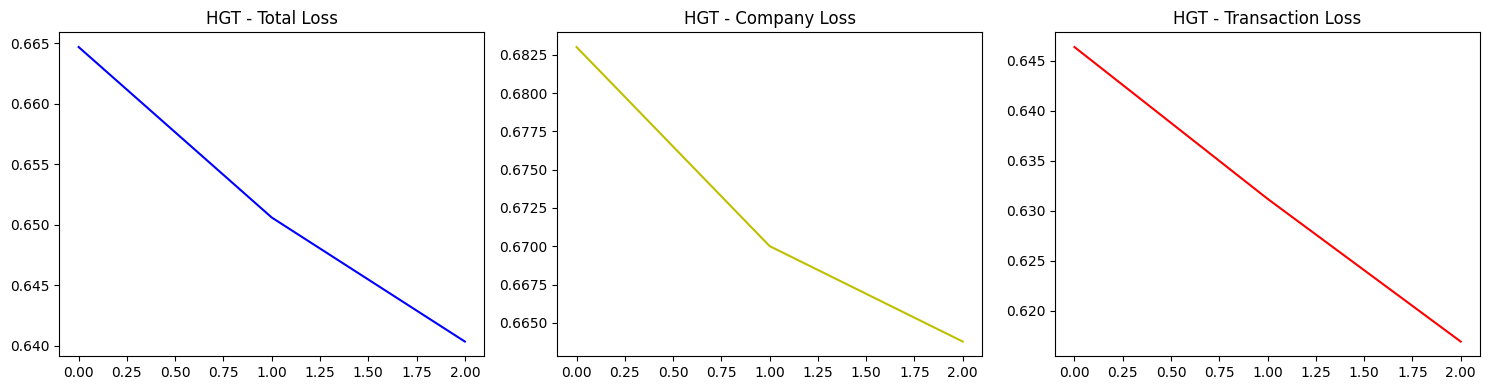


HGTNet — Resultados de Avaliação

--- Empresas (company nodes) ---
              precision    recall  f1-score   support

           0     0.7370    0.9969    0.8474      1588
           1     0.0000    0.0000    0.0000       565

    accuracy                         0.7353      2153
   macro avg     0.3685    0.4984    0.4237      2153
weighted avg     0.5436    0.7353    0.6250      2153

[[1583    5]
 [ 565    0]]
AUC-ROC (company):     0.4984

--- Transações (transaction nodes) ---
              precision    recall  f1-score   support

           0     0.9882    1.0000    0.9941      9874
           1     1.0000    0.0635    0.1194       126

    accuracy                         0.9882     10000
   macro avg     0.9941    0.5317    0.5567     10000
weighted avg     0.9883    0.9882    0.9830     10000

[[9874    0]
 [ 118    8]]
AUC-ROC (transaction): 0.5317


In [24]:
# =============================================================================
# HGTNet — Instanciação e loop de treino/avaliação
# =============================================================================

# ── Hyperparâmetros do HGT ───────────────────────────────────────────────────
HGT_HIDDEN    = 64    # dimensão interna
HGT_HEADS     = 4     # cabeças de atenção
HGT_LAYERS    = 2     # camadas HGT
HGT_DROPOUT   = 0.2
HGT_LR        = 0.001
HGT_EPOCHS    = epocas   # usa a variável global definida na Cell 2

company_feat_dim     = company_node_feature.shape[1]
transaction_feat_dim = transaction_node_feature.shape[1]

hgt_model = HGTNet(
    hidden_channels      = HGT_HIDDEN,
    num_heads            = HGT_HEADS,
    num_layers           = HGT_LAYERS,
    metadata             = hetero_data.metadata(),
    company_in_feats     = company_feat_dim,
    transaction_in_feats = transaction_feat_dim,
    num_classes          = num_classes,
    dropout              = HGT_DROPOUT,
).to(device)

hgt_optimizer = torch.optim.Adam(hgt_model.parameters(), lr=HGT_LR, weight_decay=1e-4)
hgt_scheduler = torch.optim.lr_scheduler.StepLR(hgt_optimizer, step_size=30, gamma=0.5)
loss_func_hgt = torch.nn.CrossEntropyLoss()

hgt_cost1, hgt_cost2, hgt_total = [], [], []

hgt_model.train()
print(f"[HGTNet] Iniciando treino por {HGT_EPOCHS} épocas...")
print(f"[HGTNet] Parâmetros: {sum(p.numel() for p in hgt_model.parameters()):,}")

for epoch in range(HGT_EPOCHS):
    hgt_optimizer.zero_grad()

    # Forward: passa o HeteroData para o modelo
    out_comp, out_tran = hgt_model(
        x_dict          = hetero_data.x_dict,
        edge_index_dict = hetero_data.edge_index_dict,
    )

    loss1 = loss_func_hgt(out_comp[x_train_new1], y_train_new1)
    loss2 = loss_func_hgt(out_tran[x_train_new2], y_train_new2)
    loss  = (loss1 + loss2) / 2

    loss.backward()
    hgt_optimizer.step()
    hgt_scheduler.step()

    hgt_cost1.append(loss1.item())
    hgt_cost2.append(loss2.item())
    hgt_total.append(loss.item())

    print(f'[HGTNet] Época {epoch:3d} | loss_total={loss:.4f}  loss_comp={loss1:.4f}  loss_tran={loss2:.4f}')

# ── Curvas de loss ───────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(hgt_total,  '-b'); axes[0].set_title('HGT - Total Loss')
axes[1].plot(hgt_cost1,  '-y'); axes[1].set_title('HGT - Company Loss')
axes[2].plot(hgt_cost2,  '-r'); axes[2].set_title('HGT - Transaction Loss')
plt.tight_layout(); plt.show()

# ── Avaliação ────────────────────────────────────────────────────────────────
hgt_model.eval()
with torch.no_grad():
    out_comp, out_tran = hgt_model(
        x_dict          = hetero_data.x_dict,
        edge_index_dict = hetero_data.edge_index_dict,
    )

pred_comp  = out_comp[x_test_new1].argmax(dim=1).cpu()
pred_tran  = out_tran[x_test_new2].argmax(dim=1).cpu()
y_c        = y_test_new1.cpu()
y_t        = y_test_new2.cpu()

print("\n" + "="*60)
print("HGTNet — Resultados de Avaliação")
print("="*60)
print("\n--- Empresas (company nodes) ---")
print(classification_report(y_c, pred_comp, digits=4))
print(confusion_matrix(y_c, pred_comp))
fpr, tpr, _ = roc_curve(y_c, pred_comp, pos_label=1)
print(f"AUC-ROC (company):     {auc(fpr, tpr):.4f}")

print("\n--- Transações (transaction nodes) ---")
print(classification_report(y_t, pred_tran, digits=4))
print(confusion_matrix(y_t, pred_tran))
fpr, tpr, _ = roc_curve(y_t, pred_tran, pos_label=1)
print(f"AUC-ROC (transaction): {auc(fpr, tpr):.4f}")


## MultiFraud: Train/Test

In [25]:
saveData ={
    "companies_index":companies_index,
    "transactions_index":transactions_index,
    "company_node_feature":company_node_feature,
    "new_edge_index":new_edge_index,
    "node_mapping":node_mapping,
    "transaction_node_mapping":transaction_node_mapping,
    "companies_length":companies_length,
    "new_egde_type":new_egde_type,
    "transaction_node_feature":transaction_node_feature,
    "new_edge_index_2":new_edge_index_2,
    "real_trans_edge_type":real_trans_edge_type,
    "x_train_new1":x_train_new1,
    "y_train_new1":y_train_new1,
    "x_train_new2":x_train_new2,
    "y_train_new2":y_train_new2,
    "x_test_new1":x_test_new1,
    "y_test_new1":y_test_new1,
    "x_test_new2":x_test_new2,
    "y_test_new2":y_test_new2,
}
sio.savemat("dataset/real_data_for_explain.mat", saveData)

Iter-0; Total loss: 0.7223
Iter-1; Total loss: 0.6328
Iter-2; Total loss: 0.5724


C:\Users\muril\AppData\Local\Temp\ipykernel_900\3026542984.py:44: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  plt.plot(np.squeeze(torch.tensor(costD).detach().numpy()), '-b')


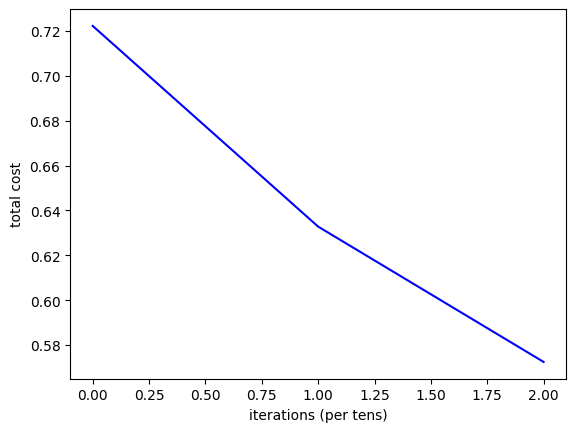

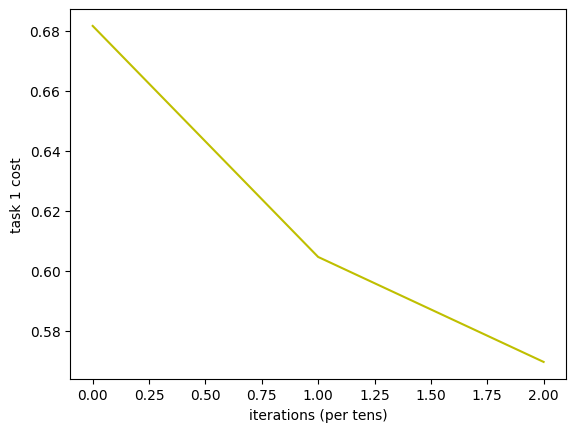

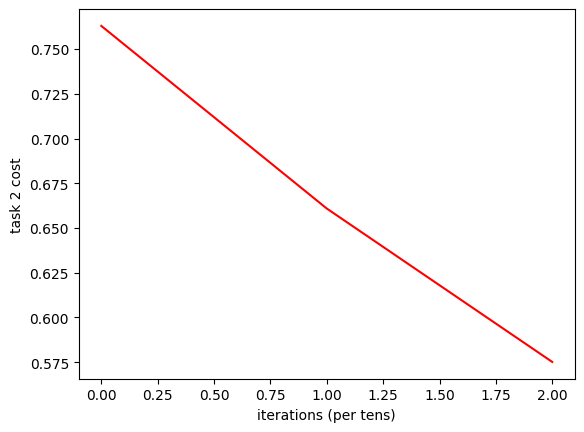

              precision    recall  f1-score   support

           0     0.7376    1.0000    0.8490      1588
           1     0.0000    0.0000    0.0000       565

    accuracy                         0.7376      2153
   macro avg     0.3688    0.5000    0.4245      2153
weighted avg     0.5440    0.7376    0.6262      2153

[[1588    0]
 [ 565    0]]
0.5
              precision    recall  f1-score   support

           0     0.9991    0.9603    0.9793      9874
           1     0.2299    0.9286    0.3685       126

    accuracy                         0.9599     10000
   macro avg     0.6145    0.9444    0.6739     10000
weighted avg     0.9894    0.9599    0.9716     10000

[[9482  392]
 [   9  117]]
0.9444356028820279
tensor([[0.0899, 0.0905, 0.0911,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],


C:\Users\muril\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\muril\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\muril\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

In [28]:


# dual test
explain_model = SingleCompNet(companies_index, transactions_index,  node_feature_size = 89, transaction_feature_size = 23, edge_type_number = 3, tran_edge_type_number = 1, dropout_rate=0.2).to(device)
#explain_model = Net(companies_index, transactions_index,  node_feature_size = 8, transaction_feature_size = 8, edge_type_number = 1, dropout_rate=0.2).to(device)
optimizer = torch.optim.Adam(explain_model.parameters(), lr=0.01)
cost1D = []
cost2D = []
costD = []

loss_func = torch.nn.CrossEntropyLoss()

# checkpoint = torch.load("./checkpoint/checkpoint_209_epoch.pkl")
# explain_model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_epoch = checkpoint['epoch']

explain_model.train()
# originalmente 300
for epoch in range(epocas):
    optimizer.zero_grad()
    out1, out2, atten_scores = explain_model(company_node_feature, new_edge_index, node_mapping, transaction_node_mapping, companies_length, new_egde_type, transaction_node_feature, new_edge_index_2, real_trans_edge_type)
    loss1 = loss_func(out1[x_train_new1] ,y_train_new1)
    loss2 = loss_func(out2[x_train_new2] ,y_train_new2)
    loss = (loss1+loss2)/2
    loss.backward()
    optimizer.step()
    cost1D.append(loss1)
    cost2D.append(loss2)
    costD.append(loss)
    print('Iter-{}; Total loss: {:.4}'.format(epoch, loss))

#     if (epoch+1) % checkpoint_interval == 0:

#         checkpoint = {"model_state_dict": explain_model.state_dict(),
#                       "optimizer_state_dict": optimizer.state_dict(),
#                       "epoch": epoch,
#                       "loss1": loss1,"loss2":loss2}
#         path_checkpoint = "./checkpoint/checkpoint_{}_epoch.pkl".format(epoch)
#         torch.save(checkpoint, path_checkpoint)

# torch.save(explain_model.state_dict(), "./checkpoint/checkpoint.pkl")

# print(atten_scores)

plt.plot(np.squeeze(torch.tensor(costD).detach().numpy()), '-b')
plt.ylabel('total cost')
plt.xlabel('iterations (per tens)')
plt.show()

plt.plot(np.squeeze(torch.tensor(cost1D).detach().numpy()), '-y')
plt.ylabel('task 1 cost')
plt.xlabel('iterations (per tens)')
plt.show()

plt.plot(np.squeeze(torch.tensor(cost2D).detach().numpy()),'-r')
plt.ylabel('task 2 cost')
plt.xlabel('iterations (per tens)')
plt.show()

explain_model.eval()

out1, out2, test_atten_scores  = explain_model(company_node_feature, new_edge_index, node_mapping, transaction_node_mapping, companies_length, new_egde_type, transaction_node_feature, new_edge_index_2, real_trans_edge_type)
pred1 = out1[x_test_new1].argmax(dim=1)
pred2 = out2[x_test_new2].argmax(dim=1)
print(classification_report(y_test_new1, pred1,digits=4))
print(confusion_matrix(y_test_new1, pred1))
fpr, tpr, thresholds = roc_curve(y_test_new1, pred1, pos_label=1)
print(auc(fpr, tpr))
print(classification_report(y_test_new2, pred2,digits=4))
print(confusion_matrix(y_test_new2, pred2))
fpr, tpr, thresholds = roc_curve(y_test_new2, pred2, pos_label=1)
print(auc(fpr, tpr))
print(test_atten_scores)

## MultiFraud-S: Train/Test

Iter-0; Total loss: 0.6856
Iter-1; Total loss: 0.516
Iter-2; Total loss: 0.3786


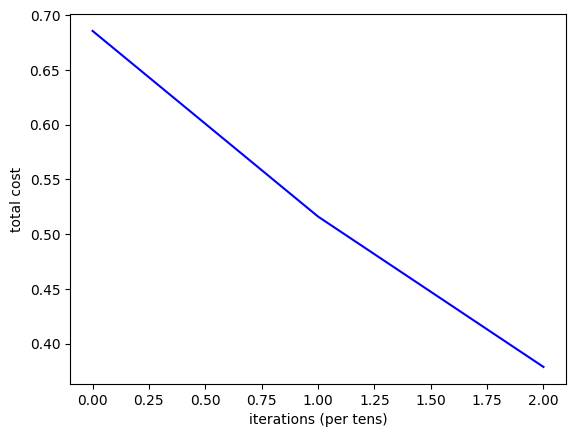

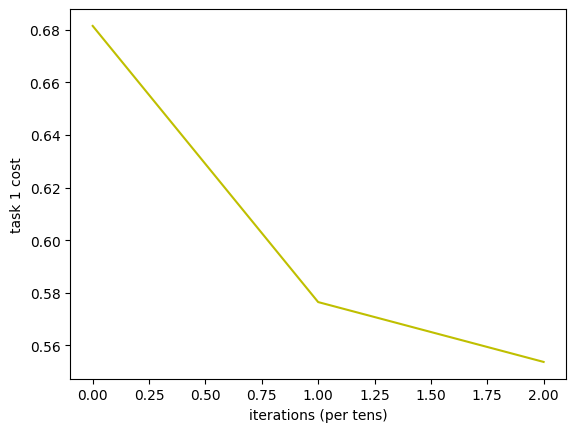

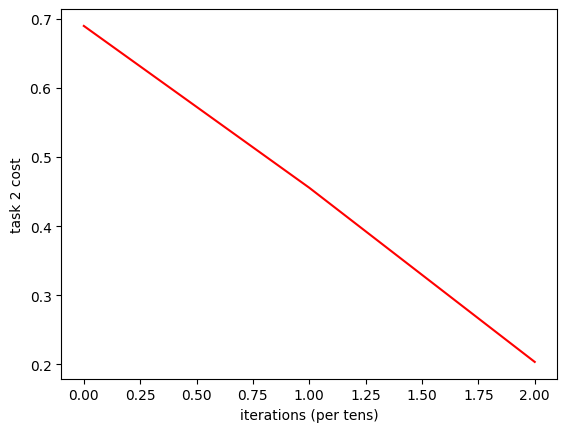

              precision    recall  f1-score   support

           0     0.7376    1.0000    0.8490      1588
           1     0.0000    0.0000    0.0000       565

    accuracy                         0.7376      2153
   macro avg     0.3688    0.5000    0.4245      2153
weighted avg     0.5440    0.7376    0.6262      2153

[[1588    0]
 [ 565    0]]
0.5
              precision    recall  f1-score   support

           0     0.9893    0.9999    0.9946      9874
           1     0.9500    0.1508    0.2603       126

    accuracy                         0.9892     10000
   macro avg     0.9696    0.5753    0.6274     10000
weighted avg     0.9888    0.9892    0.9853     10000

[[9873    1]
 [ 107   19]]
0.5753461873575302


C:\Users\muril\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\muril\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\muril\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

In [29]:
# Single Test
single_explain_model = Net(companies_index, transactions_index,  node_feature_size = 89, transaction_feature_size = 23, edge_type_number = 1, dropout_rate=0.2).to(device)
optimizer = torch.optim.Adam(single_explain_model.parameters(), lr=0.05)
cost1D = []
cost2D = []
costD = []

loss_func = torch.nn.CrossEntropyLoss()
single_explain_model.train()
# originalmente 300
for epoch in range(epocas):
    optimizer.zero_grad()
    out1, out2 = single_explain_model(company_node_feature, new_edge_index, node_mapping, transaction_node_mapping, companies_length, new_egde_type, transaction_node_feature, new_edge_index_2, real_trans_edge_type, single = True)
    loss1 = loss_func(out1[x_train_new1] ,y_train_new1)
    loss2 = loss_func(out2[x_train_new2] ,y_train_new2)
    loss = (loss1+loss2)/2
    loss.backward()
    optimizer.step()
    cost1D.append(loss1)
    cost2D.append(loss2)
    costD.append(loss)
    print('Iter-{}; Total loss: {:.4}'.format(epoch, loss))

#print(atten_scores)

plt.plot(np.squeeze(torch.tensor(costD).detach().numpy()), '-b')
plt.ylabel('total cost')
plt.xlabel('iterations (per tens)')
plt.show()

plt.plot(np.squeeze(torch.tensor(cost1D).detach().numpy()), '-y')
plt.ylabel('task 1 cost')
plt.xlabel('iterations (per tens)')
plt.show()

plt.plot(np.squeeze(torch.tensor(cost2D).detach().numpy()),'-r')
plt.ylabel('task 2 cost')
plt.xlabel('iterations (per tens)')
plt.show()

single_explain_model.eval()
out1, out2  = single_explain_model(company_node_feature, new_edge_index, node_mapping, transaction_node_mapping, companies_length, new_egde_type, transaction_node_feature, new_edge_index_2,real_trans_edge_type,single = True)
pred1 = out1[x_test_new1].argmax(dim=1)
pred2 = out2[x_test_new2].argmax(dim=1)
print(classification_report(y_test_new1, pred1, digits=4))
print(confusion_matrix(y_test_new1, pred1))
fpr, tpr, thresholds = roc_curve(y_test_new1, pred1, pos_label=1)
print(auc(fpr, tpr))
print(classification_report(y_test_new2, pred2, digits=4))
print(confusion_matrix(y_test_new2, pred2))
fpr, tpr, thresholds = roc_curve(y_test_new2, pred2, pos_label=1)
print(auc(fpr, tpr))

## Explainer

In [30]:
import matplotlib.pyplot as plt

# epochs original 1000
explainer = ModifiedGNNExplainer(explain_model, epochs=100, num_hops=3)
node_idx = 1023
# node_feat_mask, edge_mask = explainer.explain_node(node_idx,x = company_node_feature, edge_index = new_edge_index, node_mapping = node_mapping, transaction_node_mapping = transaction_node_mapping, companies_length=companies_length, new_egde_type = new_egde_type, x_2 = transaction_node_feature, edge_index2 = new_edge_index_2, explain = True)
node_feat_mask, edge_mask = explainer.explain_node(node_idx,x = company_node_feature, edge_index = new_edge_index, node_mapping = node_mapping, transaction_node_mapping = transaction_node_mapping, companies_length=companies_length, new_egde_type = new_egde_type, x_2 = transaction_node_feature, edge_index2 = new_edge_index_2, tran_new_egde_type = real_trans_edge_type, explain = True)

Explain node 1023: 100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


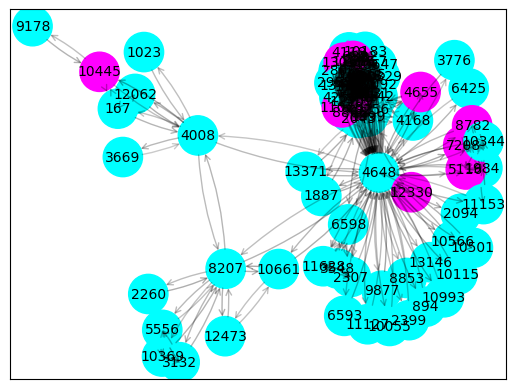

In [31]:
ax, explain_G = explainer.visualize_subgraph(node_idx, new_edge_index, edge_mask, y = torch.Tensor(role_id).int())
plt.show()

In [32]:
G = nx.Graph()

In [33]:
comp_edge_source = new_edge_index[0][edge_mask>0]
comp_edge_target = new_edge_index[1][edge_mask>0]
comp_edge_type = new_egde_type[edge_mask>0]
comp_edge_weights = edge_mask[edge_mask>0]

comps = set()

normal_comp_nodes = []
fraud_comp_nodes = []
normal_tran_nodes = []
fraud_tran_nodes = []
edge_types = []
edge_weights = []


comp_colors = ["grey", "skyblue", "firebrick"]
for index, comp in enumerate(comp_edge_source):
    #if comp.item() == node_idx or comp_edge_target[index] == node_idx:
    comps.add(comp.item())
    comps.add(comp_edge_target[index].item())
    G.add_node('e' + str(comp.item()))
    G.add_node('e' + str(comp_edge_target[index].item()))
    if G.has_edge('e' + str(comp.item()), 'e' + str(comp_edge_target[index].item())):
        G.add_edge('e' + str(comp.item()), 'e' + str(comp_edge_target[index].item()),color=comp_colors[1], weights = comp_edge_weights[index].item() + G['e' + str(comp.item())]['e' + str(comp_edge_target[index].item())]['weights'] )
    else:
        G.add_edge('e' + str(comp.item()), 'e' + str(comp_edge_target[index].item()),color=comp_colors[1], weights = comp_edge_weights[index].item())
print(comps)
for comp in comps:
    if comp != node_idx:
        if role_id[comp] == 1:
            fraud_comp_nodes.append('e' + str(comp))
        else:
            normal_comp_nodes.append('e' + str(comp))

{10369, 2307, 10115, 10501, 2955, 8207, 11153, 10131, 8853, 4118, 10647, 9877, 6425, 11675, 12062, 4256, 8866, 10661, 167, 4648, 9256, 4008, 4011, 7208, 12330, 2094, 13487, 4655, 12209, 11127, 5556, 12473, 13371, 12092, 3132, 1984, 3776, 6593, 3142, 10183, 1736, 11078, 4168, 10566, 6598, 10445, 10318, 8782, 10055, 2260, 3669, 13015, 10329, 9178, 13146, 3548, 1887, 2399, 3555, 10344, 11628, 6382, 10993, 115, 2803, 1399, 2043, 5116, 8957, 894, 1023}


In [34]:
# originalmente ephocs = 500
explainer = ModifiedGNNExplainer(explain_model, epochs=50, num_hops=3)
t_node_idx = companies_index[node_idx][test_atten_scores[node_idx].argmax()] - 1
node_feat_mask_2, edge_mask_2 = explainer.explain_node(t_node_idx ,x = transaction_node_feature, edge_index = new_edge_index_2, node_mapping = node_mapping, transaction_node_mapping = transaction_node_mapping, companies_length=companies_length, new_egde_type = new_egde_type, x_2 = company_node_feature, edge_index2 = new_edge_index,tran_new_egde_type = real_trans_edge_type, explain_type='t', explain = True)

Explain node -1: 100%|██████████| 50/50 [01:35<00:00,  1.91s/it]


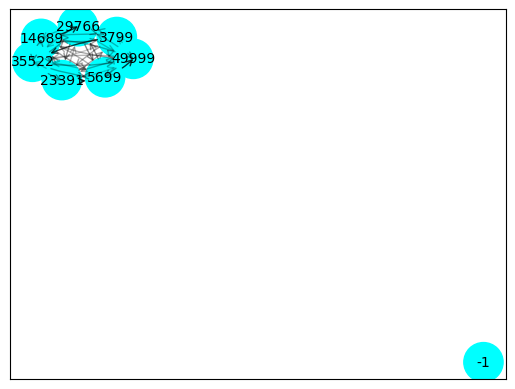

In [35]:
ax, explain_G = explainer.visualize_subgraph(t_node_idx, new_edge_index_2, edge_mask_2, y = torch.Tensor(trans_role_id).int())
plt.show()

In [36]:
tran_edge_source = new_edge_index_2[0][edge_mask_2 > 0]
tran_edge_target = new_edge_index_2[1][edge_mask_2 > 0]
#tran_edge_type = real_trans_edge_type[edge_mask_2 > 0]
tran_edge_weights = edge_mask_2[edge_mask_2 > 0]

tran_edge_source = torch.cat([tran_edge_source, new_edge_index_2[0][edge_mask_2 > 0]])
tran_edge_target = torch.cat([tran_edge_target,new_edge_index_2[1][edge_mask_2 > 0]])
#tran_edge_type = real_trans_edge_type[edge_mask_2 > 0]
tran_edge_weights = torch.cat([tran_edge_weights, edge_mask_2[edge_mask_2 > 0]])


trans = set()
tran_colors = ["orange", "peru"]
for index, tran in enumerate(tran_edge_source):
    #if tran.item() == t_node_idx or tran_edge_target[index] == t_node_idx:
    trans.add(tran.item())
    trans.add(tran_edge_target[index].item())
    G.add_node('t' + str(tran.item()))
    G.add_node('t' + str(tran_edge_target[index].item()))
    if G.has_edge('t' + str(tran.item()), 't' + str(tran_edge_target[index].item())):
        G.add_edge('t' + str(tran.item()), 't' + str(tran_edge_target[index].item()),color=tran_colors[0], weights = tran_edge_weights[index].item() + G['t' + str(tran.item())]['t' + str(tran_edge_target[index].item())]['weights'])
    else:
        G.add_edge('t' + str(tran.item()), 't' + str(tran_edge_target[index].item()),color=tran_colors[0], weights = tran_edge_weights[index].item())
print(trans)
for t in trans:
#     if t!=t_node_idx:
    if trans_role_id[t] == 1:
        fraud_tran_nodes.append('t'+str(t))
    else:
        normal_tran_nodes.append('t'+str(t))
print(fraud_tran_nodes)

G.add_edge('e' + str(node_idx), 't' + str(t_node_idx), color="green", weights=1)
# G.add_edge('e' + str(node_idx), 't' + str(t_node_idx_2), color="green", weights=0.9)

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[v][u]['weights'] for u,v in edges]

labels = {}
for node in G.nodes():
    labels[node] = node

plt.rcParams["figure.figsize"] = (32,32)

{14689, 35522, 5699, 29766, 49999, 3799, 23391}
[]


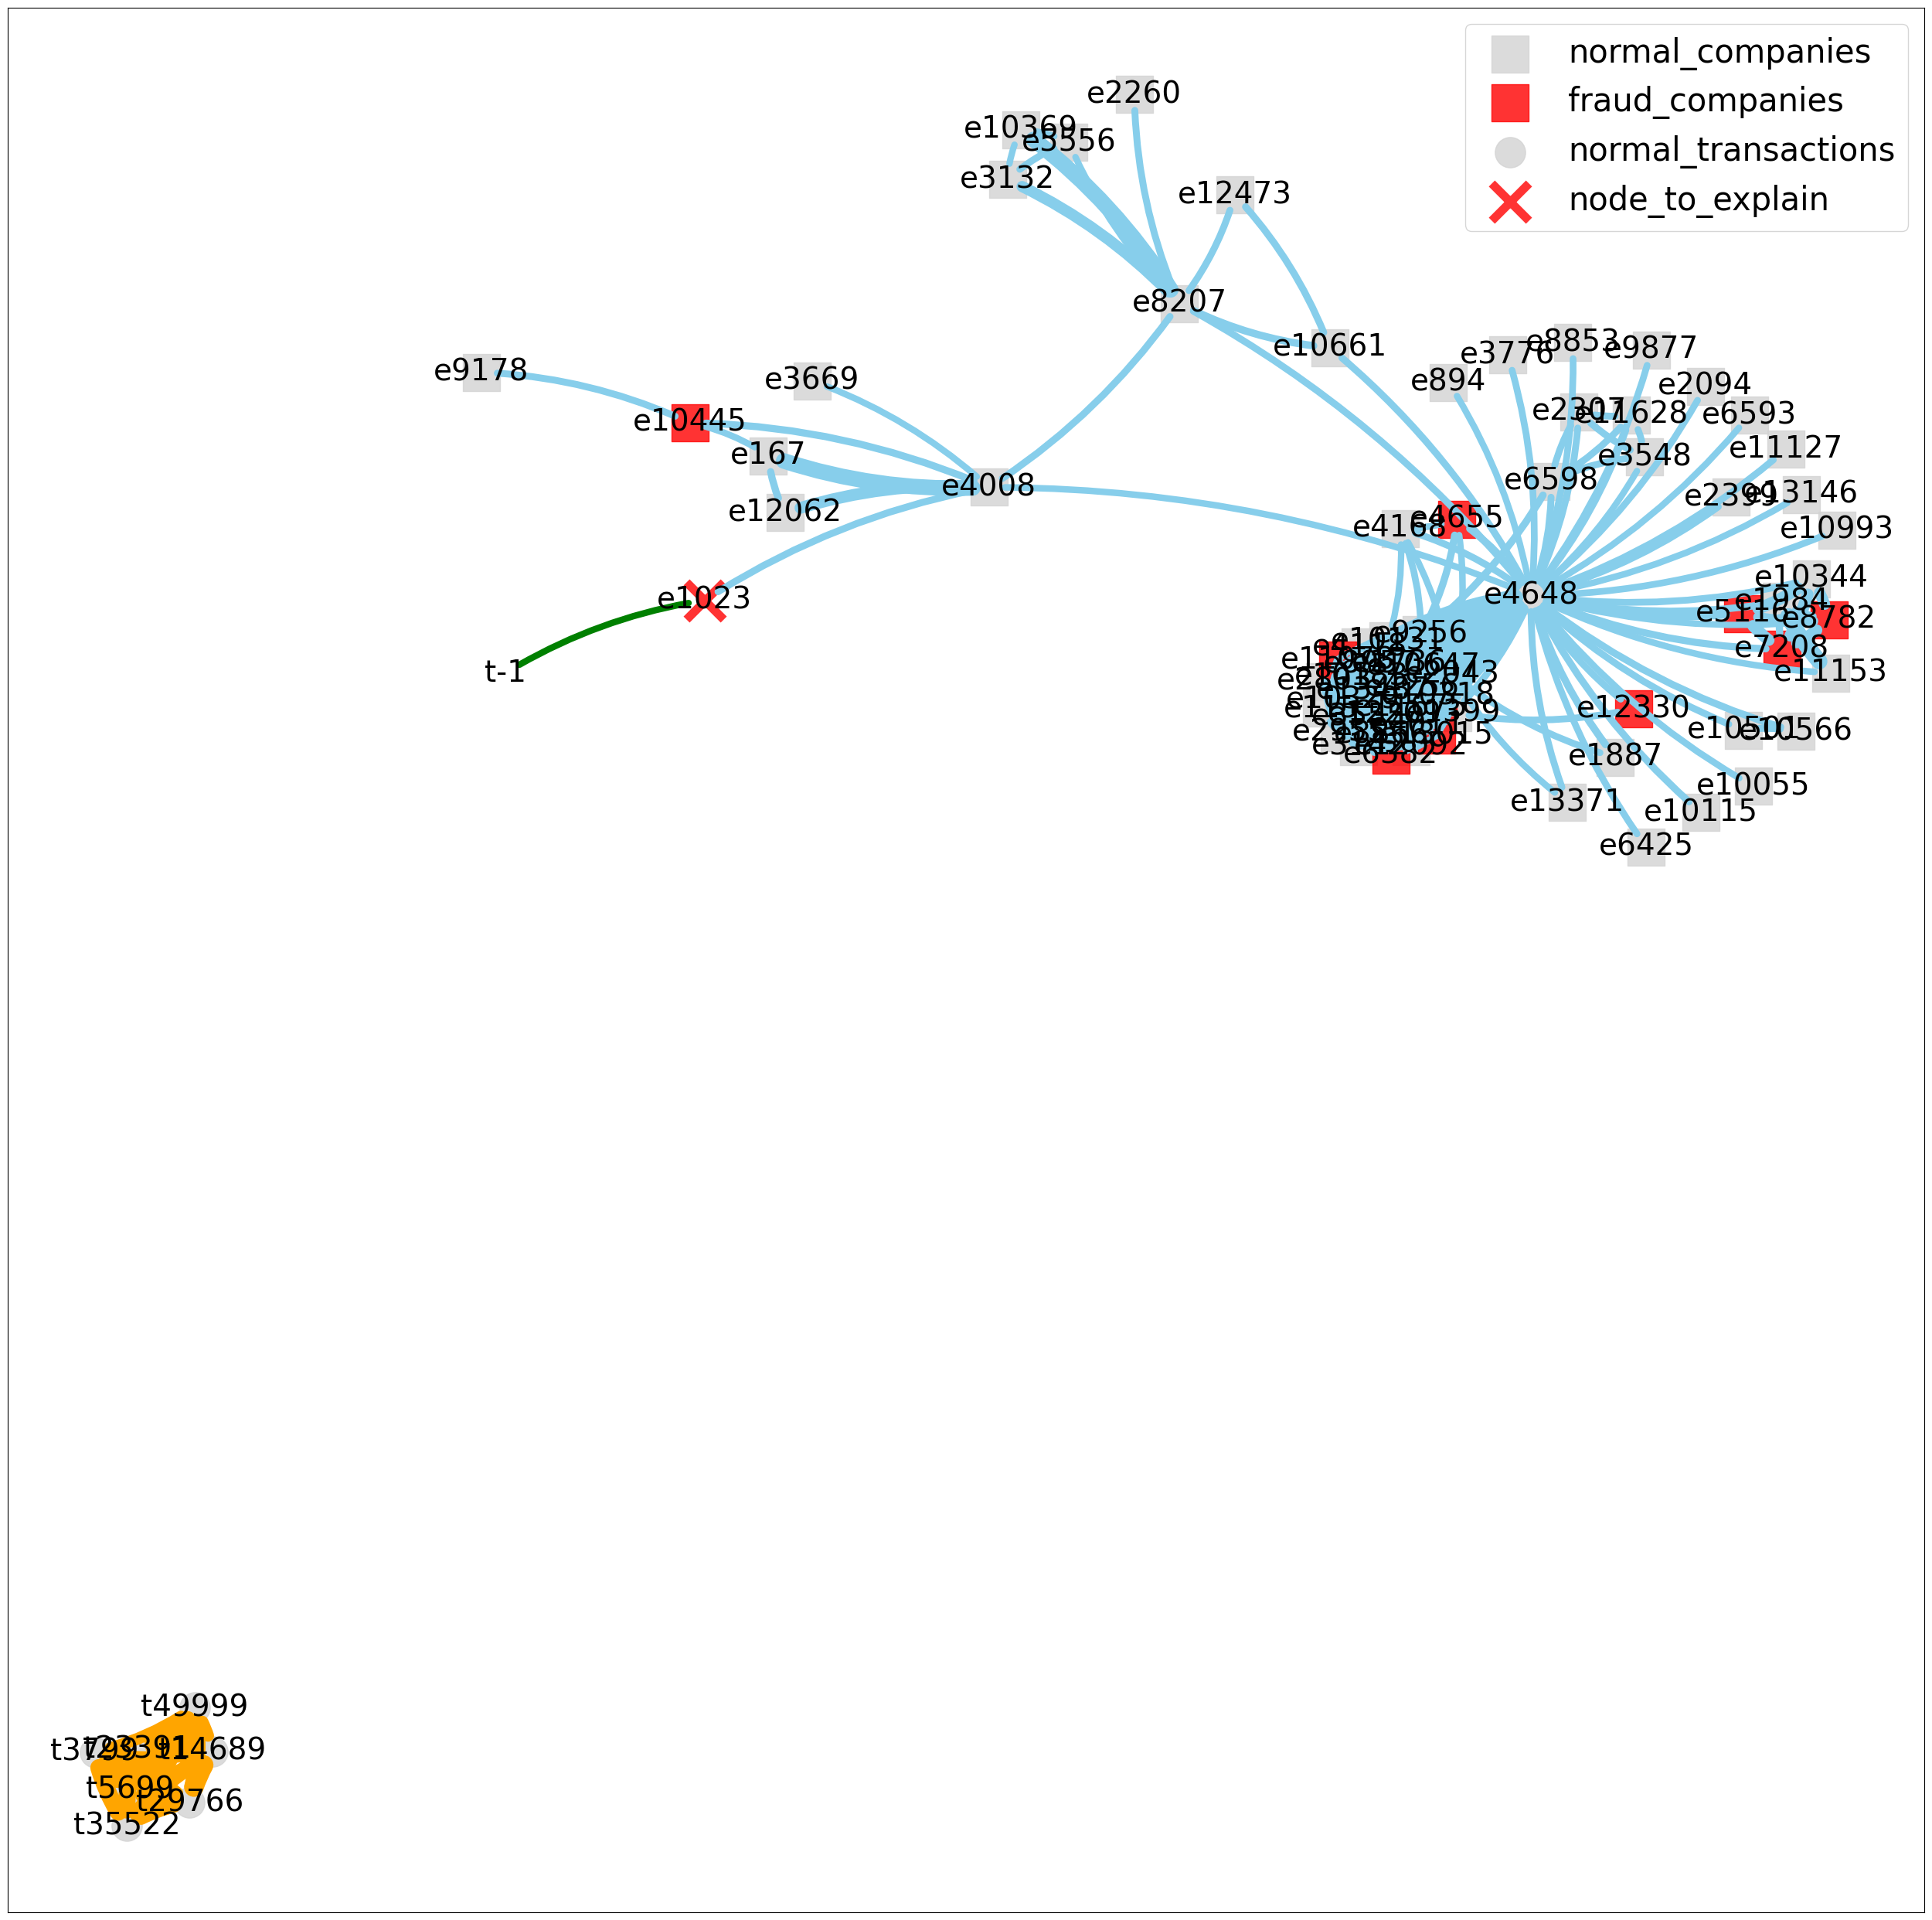

In [37]:
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos=pos, nodelist=normal_comp_nodes, node_color='lightgrey',
                           node_shape='s', label = 'normal_companies', node_size=1200, alpha = 0.8)
nx.draw_networkx_nodes(G, pos=pos, nodelist=fraud_comp_nodes, node_color='red',
                           node_shape='s', label = 'fraud_companies',node_size=1200,  alpha = 0.8)
nx.draw_networkx_nodes(G, pos=pos, nodelist=normal_tran_nodes,node_size=800, node_color='lightgrey',
                           node_shape='o', label = 'normal_transactions', alpha = 0.8)
nx.draw_networkx_nodes(G, pos=pos, nodelist=fraud_tran_nodes,node_size=800, node_color='red',
                           node_shape='o', label = 'fraud_transactions', alpha = 0.8)
nx.draw_networkx_nodes(G, pos=pos, nodelist= [ 'e'+ str(node_idx)],node_size=1200, node_color='red', node_shape='x',
                           label = 'node_to_explain', linewidths = 8,  alpha = 0.8)

ax = plt.gca()
for source, target, data in G.edges(data=True):
    ax.annotate(
        '', xy=pos[target], xycoords='data', xytext=pos[source],
        textcoords='data', arrowprops=dict(
            arrowstyle="-",
            linewidth=max(2 + 4*data['weights'], 2),
            color=data['color'],
            shrinkA=15,
            shrinkB=15,
            connectionstyle="arc3,rad=0.1",
        ))

nx.draw_networkx_labels(G,pos,labels,font_size=28,font_color='black')

plt.legend(scatterpoints = 1, loc = 'best', fontsize = 'xx-small', prop={'size':30})